In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from components.cnn_parallell import experiment4, experiment4_img, experiment6_img, experiment7_img, experiment8_img
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from components.cnn_score import score_clfs_noisy
from tensorflow import keras

2024-06-25 12:45:59.153586: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 12:45:59.156980: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 12:45:59.203148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 12:45:59.945960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def save_coefficients(path: str, data: np.ndarray, exp: str):
    folder = f"coefficients/{path}"
    os.makedirs(folder, exist_ok=True)

    file = f"{folder}/{exp}.npy"
    np.save(file, data)
    print(f"{file} saved")

def load_coefficients(path: str, exp: str):
    folder = f"coefficients/{path}"
    file = np.load(f"{folder}/{exp}.npy")
    return file

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

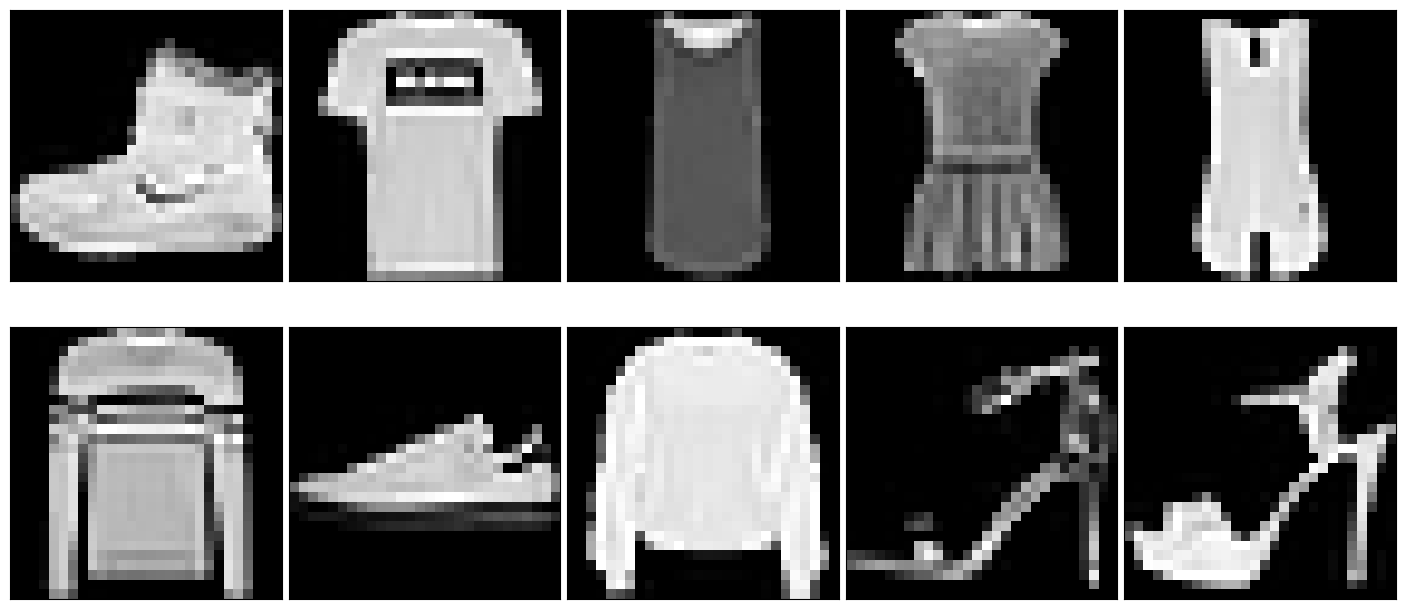

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(14, 7))
for i in range(10): 
    if i < 5:
        ax[0][i].imshow(x_train[i], cmap="gray")
        ax[0][i].set_xticks(())
        ax[0][i].set_yticks(())
    else:
        ax[1][i-5].imshow(x_train[i], cmap="gray")
        ax[1][i-5].set_xticks(())
        ax[1][i-5].set_yticks(())
    #ax[i].set_title(f"Reference image with noise {noises[i]}")
plt.tight_layout(pad=0.5)

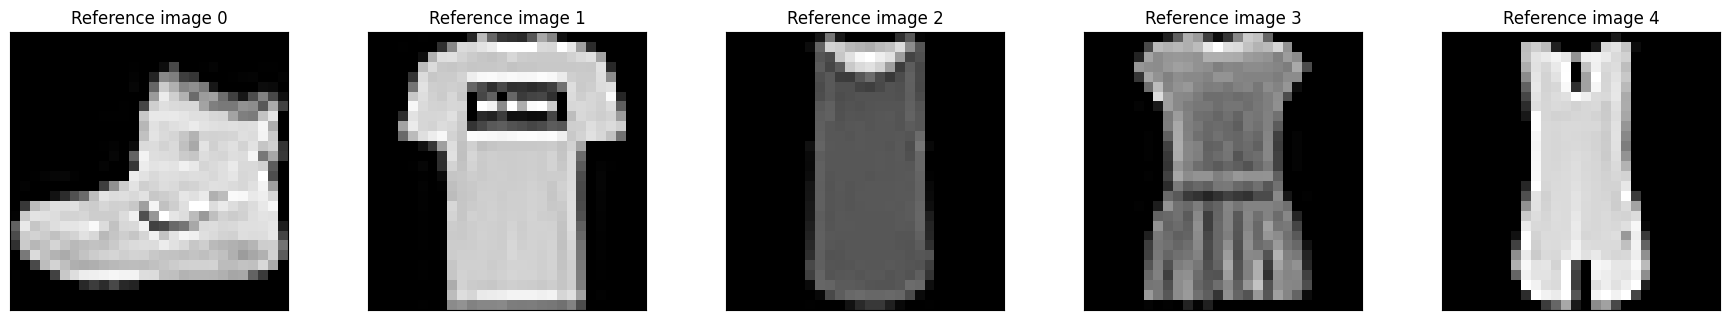

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3))
for i in range(5): 
    ax[i].imshow(x_train[i], cmap="grey")
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image {i}")
plt.tight_layout(pad=0.0)

In [7]:
plt.rcParams["figure.figsize"] = (4,3)

In [8]:
x_train = x_train / 255.
x_test = x_test / 255.
data_train = x_train[:, 1:, 1:]
data_test = x_test[:, 1:, 1:]

#y_train = y_train[:]
#y_test = y_test[:]

In [9]:
noises = [.0, .1, .2, .3, .4, .5]

noisy_test = [np.array([img + np.random.normal(.0, noise, size=(data_test[0].shape)) for img in data_test]) for noise in noises]
noisy_test_flattened = [data.reshape(-1, 27*27) for data in noisy_test]

train_flattened = data_train.reshape(-1, 27*27)

experiments = [
    "Baseline - no threshold",
    "Baseline - 0.7 threshold",
    "Baseline - 0.85 threshold",
    "Experiment 4 - only real filters",
    "Experiment 4 - with imaginary filters",
    "Experiment 6 - with imaginary filters",
    "Experiment 7 - with imaginary filters",
    "Experiment 8 - with imaginary filters"
]

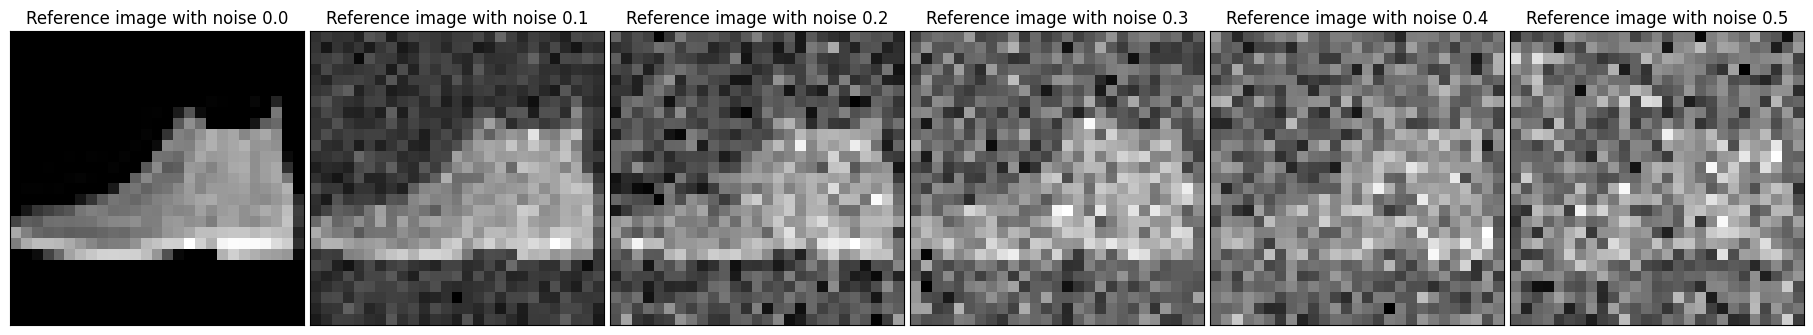

In [10]:
fig, ax = plt.subplots(1, len(noises), figsize=(18, 3))
for i in range(len(noises)): 
    ax[i].imshow(noisy_test[i][0], cmap="grey")
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image with noise {noises[i]}")
plt.tight_layout(pad=0.0)


#### Baseline - LR - No thresholding

In [10]:
scores_noisy_lr = []

In [11]:
clfs_bl = [LogisticRegression(fit_intercept=True,
                              multi_class='multinomial',
                              penalty='l2',
                              solver='saga',
                              max_iter=1000,
                              n_jobs=8,
                              tol=0.01) for _ in range(len(noises))]
baseline_lr_scores = score_clfs_noisy(clfs_bl, train_flattened, y_train, noisy_test_flattened, y_test)
scores_noisy_lr.append(baseline_lr_scores)
baseline_lr_scores

[0.843, 0.828, 0.7802, 0.7204, 0.6645, 0.6108]

#### Baseline - LR - 0.7 thresholding

In [12]:
clfs_bl_threshold1 = [LogisticRegression(fit_intercept=True,
                                         multi_class='multinomial',
                                         penalty='l2',
                                         solver='saga',
                                         max_iter=1000,
                                         n_jobs=64,
                                         tol=0.01) for _ in range(len(noises))]

train_flattened_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
noisy_test_flattened_threshold1 = [np.where(n > 0.7, n, 0.) for n in noisy_test_flattened]

baseline_lr_scores_1 = score_clfs_noisy(clfs_bl_threshold1, 
                                        train_flattened_threshold1, 
                                        y_train, 
                                        noisy_test_flattened_threshold1, 
                                        y_test)

scores_noisy_lr.append(baseline_lr_scores_1)
baseline_lr_scores_1

[0.7314, 0.7286, 0.7165, 0.6899, 0.6066, 0.4875]

#### Baseline - LR - 0.85 thresholding

In [13]:
clfs_bl_threshold2 = [LogisticRegression(fit_intercept=True,
                                         multi_class='multinomial',
                                         penalty='l2',
                                         solver='saga',
                                         max_iter=1000,
                                         n_jobs=64,
                                         tol=0.01) for _ in range(len(noises))]

train_flattened_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
noisy_test_flattened_threshold2 = [np.where(n > 0.85, n, 0.) for n in noisy_test_flattened]

baseline_lr_scores_2 = score_clfs_noisy(clfs_bl_threshold2, 
                                        train_flattened_threshold2, 
                                        y_train, 
                                        noisy_test_flattened_threshold2, 
                                        y_test)

scores_noisy_lr.append(baseline_lr_scores_2)
baseline_lr_scores_2

[0.641, 0.6482, 0.6698, 0.6611, 0.6157, 0.5086]

#### Experiment 4 - Only real filters

In [9]:
""" exp_4_train_transformed = experiment4(data_train)
exp_4_test_transformed = [experiment4(test) for test in noisy_test] """

exp_4_train_transformed = load_coefficients("train", "experiment_4_train_fashoin_mnist")
exp_4_test_transformed = [load_coefficients("test/experiment4", f"noise_test_{i}_fashion_mnist") for i in range(len(noises))]

In [16]:
clfs_lr_ex4 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp4_score = score_clfs_noisy(clfs_lr_ex4, exp_4_train_transformed, y_train, exp_4_test_transformed, y_test)
scores_noisy_lr.append(lr_noisy_exp4_score)
lr_noisy_exp4_score

[0.7933, 0.5978, 0.5292, 0.442, 0.3721, 0.3058]

In [10]:
save_coefficients("train", exp_4_train_transformed, "experiment_4_train_fashoin_mnist")
[save_coefficients("test/experiment4", t, f"noise_test_{i}_fashion_mnist") for i, t in enumerate(exp_4_test_transformed)]

coefficients/train/experiment_4_train_fashoin_mnist.npy saved
coefficients/test/experiment4/noise_test_0_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_1_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_2_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_3_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_4_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_5_fashion_mnist.npy saved


[None, None, None, None, None, None]

#### Experiment 4 - With imaginary filters

In [11]:
""" exp_4_train_transformed_img = experiment4_img(data_train)
exp_4_test_transformed_img = [experiment4_img(test) for test in noisy_test] """

exp_4_train_transformed_img = load_coefficients("train", "experiment_4_img_train_fashoin_mnist")
exp_4_test_transformed_img = [load_coefficients("test/experiment4_img", f"noise_test_{i}_img_fashion_mnist") for i in range(len(noises))]

In [18]:
clfs_lr_ex4_img = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp4_score_img = score_clfs_noisy(clfs_lr_ex4_img, exp_4_train_transformed_img, y_train, exp_4_test_transformed_img, y_test)
scores_noisy_lr.append(lr_noisy_exp4_score_img)
lr_noisy_exp4_score_img

[0.8012, 0.6175, 0.5553, 0.4549, 0.3695, 0.301]

In [12]:
save_coefficients("train", exp_4_train_transformed_img, "experiment_4_img_train_fashoin_mnist")
[save_coefficients("test/experiment4_img", t, f"noise_test_{i}_img_fashion_mnist") for i, t in enumerate(exp_4_test_transformed_img)]

coefficients/train/experiment_4_img_train_fashoin_mnist.npy saved
coefficients/test/experiment4_img/noise_test_0_img_fashion_mnist.npy saved
coefficients/test/experiment4_img/noise_test_1_img_fashion_mnist.npy saved
coefficients/test/experiment4_img/noise_test_2_img_fashion_mnist.npy saved
coefficients/test/experiment4_img/noise_test_3_img_fashion_mnist.npy saved
coefficients/test/experiment4_img/noise_test_4_img_fashion_mnist.npy saved
coefficients/test/experiment4_img/noise_test_5_img_fashion_mnist.npy saved


[None, None, None, None, None, None]

#### Experiment 6

In [13]:
""" exp_6_train_transformed_img = experiment6_img(data_train, threshold=0.85)
exp_6_test_transformed_img = [experiment6_img(test, threshold=0.85) for test in noisy_test] """

exp_6_train_transformed_img = load_coefficients("train", "experiment_6_img_train_fashoin_mnist")
exp_6_test_transformed_img = [load_coefficients("test/experiment6_img", f"noise_test_{i}_img_fashion_mnist") for i in range(len(noises))]

In [21]:
clfs_lr_ex6_img = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp6_score_img = score_clfs_noisy(clfs_lr_ex6_img, exp_6_train_transformed_img, y_train, exp_6_test_transformed_img, y_test)
scores_noisy_lr.append(lr_noisy_exp6_score_img)
lr_noisy_exp6_score_img

[0.7445, 0.7335, 0.6767, 0.5528, 0.3736, 0.2167]

In [22]:
save_coefficients("train", exp_6_train_transformed_img, "experiment_6_img_train_fashoin_mnist")
[save_coefficients("test/experiment6_img", t, f"noise_test_{i}_img_fashion_mnist") for i, t in enumerate(exp_6_test_transformed_img)]

coefficients/train/experiment_6_img_train_fashoin_mnist.npy saved
coefficients/test/experiment6_img/noise_test_0_img_fashion_mnist.npy saved
coefficients/test/experiment6_img/noise_test_1_img_fashion_mnist.npy saved
coefficients/test/experiment6_img/noise_test_2_img_fashion_mnist.npy saved
coefficients/test/experiment6_img/noise_test_3_img_fashion_mnist.npy saved
coefficients/test/experiment6_img/noise_test_4_img_fashion_mnist.npy saved
coefficients/test/experiment6_img/noise_test_5_img_fashion_mnist.npy saved


[None, None, None, None, None, None]

#### Experiment 7

In [14]:
""" exp_7_train_transformed_img = experiment7_img(data_train, grids=[(3, 3), (2, 5), (1, 7)])
exp_7_test_transformed_img = [experiment7_img(test, grids=[(3, 3), (2, 5), (1, 7)]) for test in noisy_test] """

exp_7_train_transformed_img = load_coefficients("train", "experiment_7_img_train_fashoin_mnist")
exp_7_test_transformed_img = [load_coefficients("test/experiment7_img", f"noise_test_{i}_img_fashion_mnist") for i in range(len(noises))]

In [25]:
clfs_lr_ex7_img = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp7_score_img = score_clfs_noisy(clfs_lr_ex7_img, exp_7_train_transformed_img, y_train, exp_7_test_transformed_img, y_test)
scores_noisy_lr.append(lr_noisy_exp7_score_img)
lr_noisy_exp7_score_img

[0.7829, 0.7259, 0.6483, 0.5498, 0.4678, 0.3927]

In [26]:
save_coefficients("train", exp_7_train_transformed_img, "experiment_7_img_train_fashoin_mnist")
[save_coefficients("test/experiment7_img", t, f"noise_test_{i}_img_fashion_mnist") for i, t in enumerate(exp_7_test_transformed_img)]

coefficients/train/experiment_7_img_train_fashoin_mnist.npy saved
coefficients/test/experiment7_img/noise_test_0_img_fashion_mnist.npy saved
coefficients/test/experiment7_img/noise_test_1_img_fashion_mnist.npy saved
coefficients/test/experiment7_img/noise_test_2_img_fashion_mnist.npy saved
coefficients/test/experiment7_img/noise_test_3_img_fashion_mnist.npy saved
coefficients/test/experiment7_img/noise_test_4_img_fashion_mnist.npy saved
coefficients/test/experiment7_img/noise_test_5_img_fashion_mnist.npy saved


[None, None, None, None, None, None]

#### Experiment 8

In [15]:
""" exp_8_train_transformed_img = experiment8_img(data_train, threshold=0.7, grids=[(3, 3), (2, 5), (1, 7)])
exp_8_test_transformed_img = [experiment8_img(test, threshold=0.7, grids=[(3, 3), (2, 5), (1, 7)]) for test in noisy_test] """

exp_8_train_transformed_img = load_coefficients("train", "experiment_8_img_train_fashoin_mnist")
exp_8_test_transformed_img = [load_coefficients("test/experiment8_img", f"noise_test_{i}_img_fashion_mnist") for i in range(len(noises))]

In [28]:
clfs_lr_ex8_img = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp8_score_img = score_clfs_noisy(clfs_lr_ex8_img, exp_8_train_transformed_img, y_train, exp_8_test_transformed_img, y_test)
scores_noisy_lr.append(lr_noisy_exp8_score_img)
lr_noisy_exp8_score_img

[0.759, 0.7284, 0.6679, 0.5724, 0.4888, 0.4274]

In [29]:
save_coefficients("train", exp_8_train_transformed_img, "experiment_8_img_train_fashoin_mnist")
[save_coefficients("test/experiment8_img", t, f"noise_test_{i}_img_fashion_mnist") for i, t in enumerate(exp_8_test_transformed_img)]

coefficients/train/experiment_8_img_train_fashoin_mnist.npy saved
coefficients/test/experiment8_img/noise_test_0_img_fashion_mnist.npy saved
coefficients/test/experiment8_img/noise_test_1_img_fashion_mnist.npy saved
coefficients/test/experiment8_img/noise_test_2_img_fashion_mnist.npy saved
coefficients/test/experiment8_img/noise_test_3_img_fashion_mnist.npy saved
coefficients/test/experiment8_img/noise_test_4_img_fashion_mnist.npy saved
coefficients/test/experiment8_img/noise_test_5_img_fashion_mnist.npy saved


[None, None, None, None, None, None]

Text(0.5, 0.98, 'Trained on fashoin MNIST with LR estimator, tested on noisy images. \nTrained on 60000 images. Tested on 10000 images')

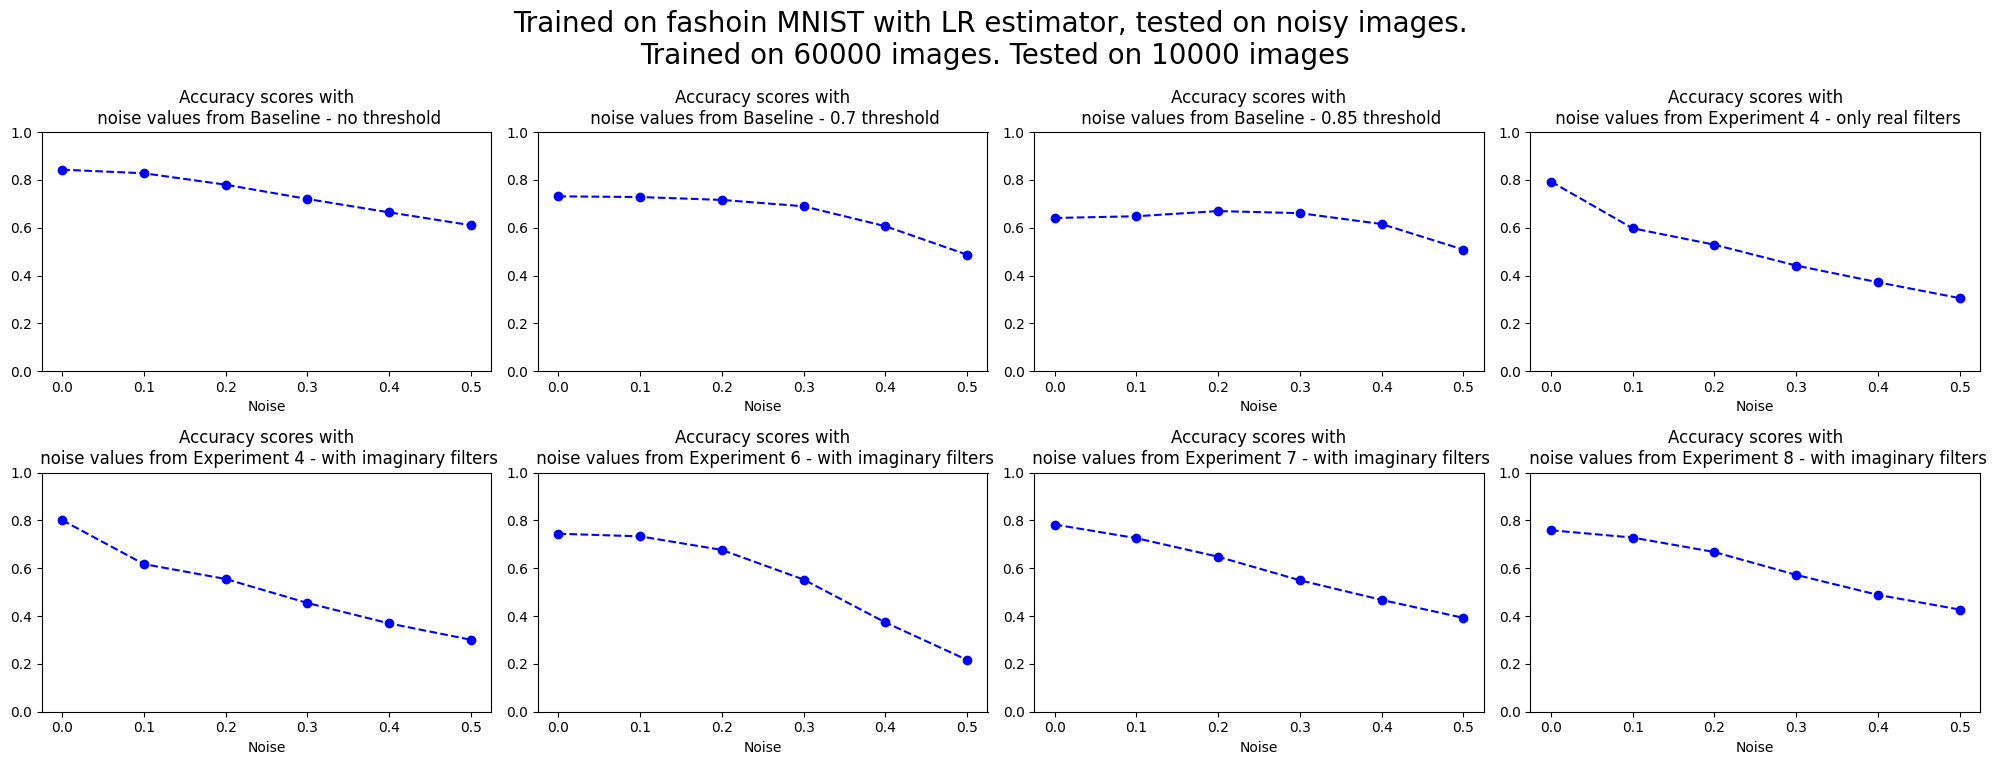

In [49]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in noises], scores_noisy_lr[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on fashoin MNIST with LR estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### SVM

In [30]:
scores_noisy_svm = []

In [31]:
clfs_svm_bl = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(noises))]
baseline_svm_scores = score_clfs_noisy(clfs_svm_bl, train_flattened, y_train, noisy_test_flattened, y_test)
scores_noisy_svm.append(baseline_svm_scores)
baseline_svm_scores

[0.8694, 0.8614, 0.8357, 0.7531, 0.6201, 0.5011]

#### Baseline - SVM - 0.7 threshold

In [32]:
clfs_svm_bl_thr1 = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(noises))]

train_flattened_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
noisy_test_flattened_threshold1 = [np.where(n > 0.7, n, 0.) for n in noisy_test_flattened]

baseline_svm_scores_thr1 = score_clfs_noisy(clfs_svm_bl_thr1, train_flattened_threshold1, y_train, noisy_test_flattened_threshold1, y_test)
scores_noisy_svm.append(baseline_svm_scores_thr1)
baseline_svm_scores_thr1

[0.7682, 0.7717, 0.7617, 0.7379, 0.6529, 0.504]

#### Baseline - SVM - 0.85 threshold

In [33]:
clfs_svm_bl_thr2 = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(noises))]

train_flattened_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
noisy_test_flattened_threshold2 = [np.where(n > 0.85, n, 0.) for n in noisy_test_flattened]

baseline_svm_scores_thr2 = score_clfs_noisy(clfs_svm_bl_thr2, train_flattened_threshold2, y_train, noisy_test_flattened_threshold2, y_test)
scores_noisy_svm.append(baseline_svm_scores_thr2)
baseline_svm_scores_thr2

[0.6606, 0.6788, 0.6958, 0.6985, 0.6441, 0.5258]

#### Experiment 4 - Only real filters

In [34]:
clfs_svm_exp4 = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp4_svm = score_clfs_noisy(clfs_svm_exp4, exp_4_train_transformed, y_train, exp_4_test_transformed, y_test)
scores_noisy_svm.append(scores_noisy_exp4_svm)
scores_noisy_exp4_svm

[0.8355, 0.6679, 0.5778, 0.4541, 0.363, 0.2945]

#### Experiment 4 - With imaginary filters


In [35]:
clfs_svm_exp4_img = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp4_svm_img = score_clfs_noisy(clfs_svm_exp4_img, exp_4_train_transformed_img, y_train, exp_4_test_transformed_img, y_test)
scores_noisy_svm.append(scores_noisy_exp4_svm_img)
scores_noisy_exp4_svm_img

[0.8426, 0.6456, 0.5631, 0.432, 0.3367, 0.2787]

#### Experiment 6

In [36]:
clfs_svm_exp6_img = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp6_svm_img = score_clfs_noisy(clfs_svm_exp6_img, exp_6_train_transformed_img, y_train, exp_6_test_transformed_img, y_test)
scores_noisy_svm.append(scores_noisy_exp6_svm_img)
scores_noisy_exp6_svm_img

[0.7989, 0.7759, 0.6883, 0.5101, 0.3298, 0.1899]

#### Experiment 7


In [37]:
clfs_svm_exp7_img = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp7_svm_img = score_clfs_noisy(clfs_svm_exp7_img, exp_7_train_transformed_img, y_train, exp_7_test_transformed_img, y_test)
scores_noisy_svm.append(scores_noisy_exp7_svm_img)
scores_noisy_exp7_svm_img

[0.8139, 0.739, 0.6385, 0.5158, 0.4391, 0.3761]

#### Experiment 8

In [38]:
clfs_svm_exp8_img = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp8_svm_img = score_clfs_noisy(clfs_svm_exp8_img, exp_8_train_transformed_img, y_train, exp_8_test_transformed_img, y_test)
scores_noisy_svm.append(scores_noisy_exp8_svm_img)
scores_noisy_exp8_svm_img

[0.7958, 0.7664, 0.6889, 0.5784, 0.4964, 0.4261]

Text(0.5, 0.98, 'Trained on fashoin MNIST with SVM estimator, tested on noisy images. \nTrained on 60000 images. Tested on 10000 images')

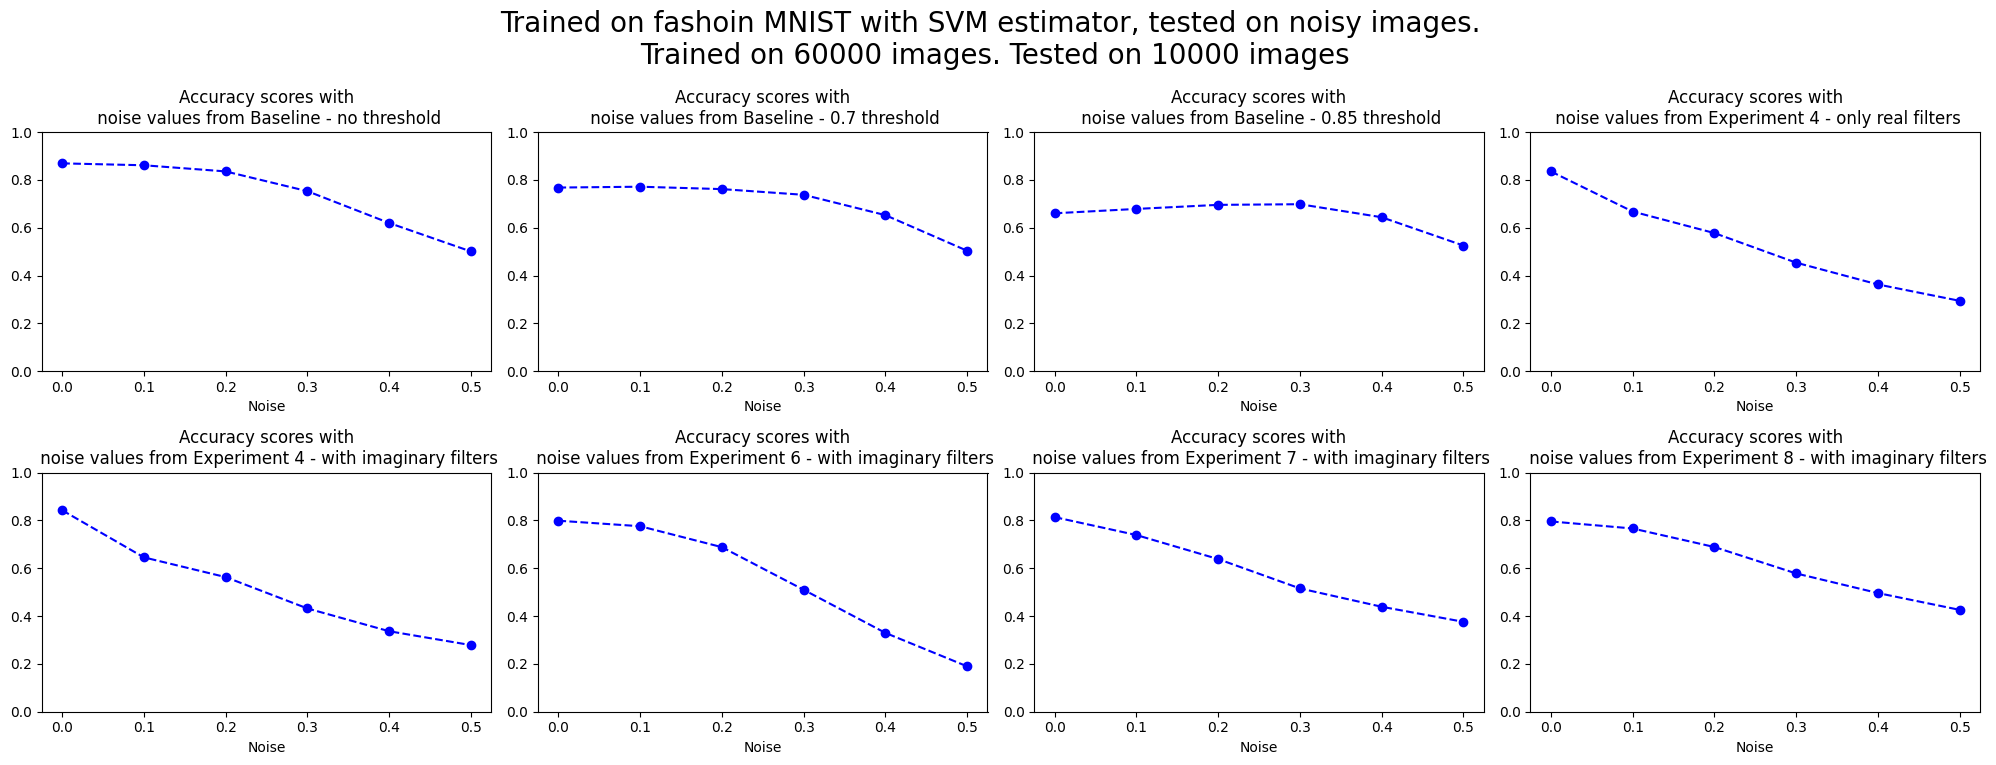

In [50]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in noises], scores_noisy_svm[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on fashoin MNIST with SVM estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### KNN

In [39]:
scores_noisy_knn = []

#### Baseline - KNN - No thresholding

In [40]:
clfs_knn_bl = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores = score_clfs_noisy(clfs_knn_bl, train_flattened, y_train, noisy_test_flattened, y_test)
scores_noisy_knn.append(baseline_knn_scores)
baseline_knn_scores

[0.8533, 0.8521, 0.8471, 0.8405, 0.8365, 0.8282]

#### Baseline - KNN - 0.7 thresholding

In [41]:
clfs_knn_bl_thr1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr1 = score_clfs_noisy(clfs_knn_bl_thr1, train_flattened_threshold1, y_train, noisy_test_flattened_threshold1, y_test)
scores_noisy_knn.append(baseline_knn_scores_thr1)
baseline_knn_scores_thr1

[0.7123, 0.7168, 0.7155, 0.7243, 0.7291, 0.7305]

#### Baseline - KNN - 0.85 thresholding

In [42]:
clfs_knn_bl_thr2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr2 = score_clfs_noisy(clfs_knn_bl_thr2, train_flattened_threshold2, y_train, noisy_test_flattened_threshold2, y_test)
scores_noisy_knn.append(baseline_knn_scores_thr2)
baseline_knn_scores_thr2

[0.5828, 0.5718, 0.5717, 0.5916, 0.6126, 0.6272]

#### Experiment 4 - Only real filters

In [43]:
clfs_knn_exp4 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp4_knn = score_clfs_noisy(clfs_knn_exp4, exp_4_train_transformed, y_train, exp_4_test_transformed, y_test)
scores_noisy_knn.append(scores_noisy_exp4_knn)
scores_noisy_exp4_knn

[0.8218, 0.5686, 0.4824, 0.3728, 0.2806, 0.2128]

#### Experiment 4 - With imaginary filters

In [44]:
clfs_knn_exp4_img = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp4_knn_img = score_clfs_noisy(clfs_knn_exp4_img, exp_4_train_transformed_img, y_train, exp_4_test_transformed_img, y_test)
scores_noisy_knn.append(scores_noisy_exp4_knn_img)
scores_noisy_exp4_knn_img

[0.8248, 0.5917, 0.4995, 0.3754, 0.2798, 0.2142]

#### Experiment 6

In [45]:
clfs_knn_exp6_img = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp6_knn_img = score_clfs_noisy(clfs_knn_exp6_img, exp_6_train_transformed_img, y_train, exp_6_test_transformed_img, y_test)
scores_noisy_knn.append(scores_noisy_exp6_knn_img)
scores_noisy_exp6_knn_img

[0.7643, 0.7403, 0.6549, 0.514, 0.3275, 0.1682]

#### Experiment 7

In [46]:
clfs_knn_exp7_img = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp7_knn_img = score_clfs_noisy(clfs_knn_exp7_img, exp_7_train_transformed_img, y_train, exp_7_test_transformed_img, y_test)
scores_noisy_knn.append(scores_noisy_exp7_knn_img)
scores_noisy_exp7_knn_img

[0.7911, 0.7273, 0.6363, 0.5232, 0.4036, 0.3176]

#### Experiment 8

In [47]:
clfs_knn_exp8_img = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp8_knn_img = score_clfs_noisy(clfs_knn_exp8_img, exp_8_train_transformed_img, y_train, exp_8_test_transformed_img, y_test)
scores_noisy_knn.append(scores_noisy_exp8_knn_img)
scores_noisy_exp8_knn_img

[0.7761, 0.7329, 0.6754, 0.6108, 0.5547, 0.4976]

Text(0.5, 0.98, 'Trained on fashoin MNIST with KNN estimator, tested on noisy images. \nTrained on 60000 images. Tested on 10000 images')

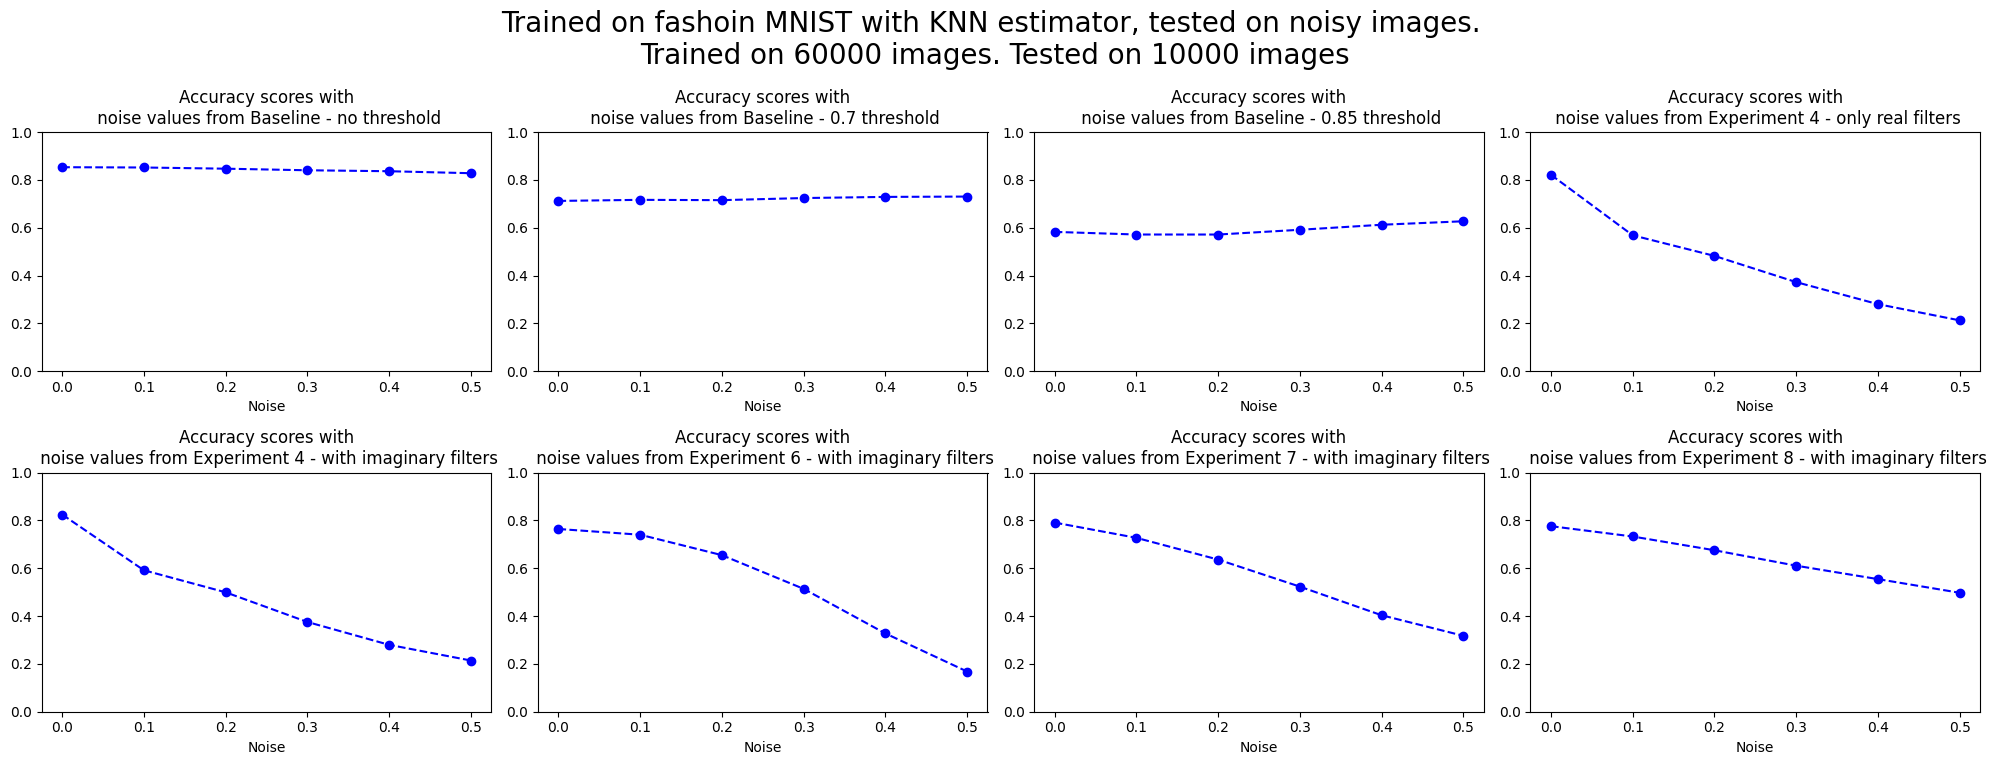

In [51]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in noises], scores_noisy_knn[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on fashoin MNIST with KNN estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

## Blackout

In [76]:
def black_out_section(image, size):
    offset = 28 - size
    start_row = np.random.randint(3, offset-3)
    start_col = np.random.randint(3, offset-3)
    image_copy = image.copy()
    image_copy[start_row:start_row+size, start_col:start_col+size] = 0
    return image_copy

blackout_sizes = np.arange(0, 18, 3)
blackout_tests = [np.array([black_out_section(img, size) for img in data_test]) for size in blackout_sizes]

### LR

In [77]:
scores_blackout_lr = []
blackout_test_flattened = [data.reshape(-1, 27*27) for data in blackout_tests]

#### LR - No thresholding

In [13]:
clfs_bl_lr = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=0.01) for _ in range(len(blackout_sizes))]

scores_blackout_baseline_lr = score_clfs_noisy(clfs_bl_lr, train_flattened, y_train, blackout_test_flattened, y_test)
scores_blackout_lr.append(scores_blackout_baseline_lr)
scores_blackout_baseline_lr

[0.8431, 0.8328, 0.7946, 0.7324, 0.658, 0.5904]

#### LR - 0.7 thresholding

In [14]:
clfs_bl_lr_thr1 = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=0.01) for _ in range(len(blackout_sizes))]

train_flattened_blackout_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
test_flattened_blackout_threshold1 = [np.where(n > 0.7, n, 0.) for n in blackout_test_flattened]

scores_blackout_baseline_lr_thr1 = score_clfs_noisy(clfs_bl_lr_thr1, 
                                                    train_flattened_blackout_threshold1, 
                                                    y_train, 
                                                    test_flattened_blackout_threshold1, 
                                                    y_test)

scores_blackout_lr.append(scores_blackout_baseline_lr_thr1)
scores_blackout_baseline_lr_thr1

[0.731, 0.728, 0.7142, 0.6873, 0.6517, 0.6132]

#### LR - 0.85 thresholding

In [15]:
clfs_bl_lr_thr2 = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=0.01) for _ in range(len(blackout_sizes))]

train_flattened_blackout_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
test_flattened_blackout_threshold2 = [np.where(n > 0.85, n, 0.) for n in blackout_test_flattened]

scores_blackout_baseline_lr_thr2 = score_clfs_noisy(clfs_bl_lr_thr2, 
                                                    train_flattened_blackout_threshold2, 
                                                    y_train, 
                                                    test_flattened_blackout_threshold2, 
                                                    y_test)

scores_blackout_lr.append(scores_blackout_baseline_lr_thr2)
scores_blackout_baseline_lr_thr2

[0.6413, 0.6389, 0.629, 0.6118, 0.5789, 0.5379]

#### LR - Experiment 4 - only real filters

In [22]:
exp_4_test_blackout_transformed = [experiment4(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [23]:
clfs_lr_ex4_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=0.01) for _ in range(len(blackout_sizes))]

scores_blackout_exp4_lr = score_clfs_noisy(clfs_lr_ex4_blackout, 
                                           exp_4_train_transformed, 
                                           y_train, 
                                           exp_4_test_blackout_transformed, 
                                           y_test)

scores_blackout_lr.append(scores_blackout_exp4_lr)
scores_blackout_exp4_lr

[0.7832, 0.7784, 0.7505, 0.6487, 0.4769, 0.3261]

#### LR - Experiment 4 - with imaginary filters

In [24]:
exp_4_img_test_blackout_transformed = [experiment4_img(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [25]:
clfs_lr_ex4_img_blackout = [LogisticRegression(fit_intercept=True,
                                               multi_class='multinomial',
                                               penalty='l2',
                                               solver='saga',
                                               max_iter=1000,
                                               n_jobs=8,
                                               tol=0.01) for _ in range(len(blackout_sizes))]

scores_blackout_exp4_img_lr = score_clfs_noisy(clfs_lr_ex4_blackout, 
                                            exp_4_train_transformed_img, 
                                            y_train, 
                                            exp_4_img_test_blackout_transformed, 
                                            y_test)

scores_blackout_lr.append(scores_blackout_exp4_img_lr)
scores_blackout_exp4_img_lr

[0.7936, 0.789, 0.7607, 0.665, 0.5092, 0.3608]

#### LR - Experiment 6

In [26]:
exp_6_img_test_blackout_transformed = [experiment6_img(test, threshold=0.85) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [27]:
clfs_lr_ex6_img_blackout = [LogisticRegression(fit_intercept=True,
                                               multi_class='multinomial',
                                               penalty='l2',
                                               solver='saga',
                                               max_iter=1000,
                                               n_jobs=64,
                                               tol=0.001) for _ in range(len(noises))]

scores_blackout_exp6_img_lr = score_clfs_noisy(clfs_lr_ex6_img_blackout, 
                                               exp_6_train_transformed_img, 
                                               y_train, 
                                               exp_6_img_test_blackout_transformed, 
                                               y_test)

scores_blackout_lr.append(scores_blackout_exp6_img_lr)
scores_blackout_exp6_img_lr

[0.7446, 0.7408, 0.7165, 0.6461, 0.5463, 0.4705]

#### LR - Experiment 7

In [28]:
exp_7_img_test_blackout_transformed = [experiment7_img(test, grids=[(3, 3), (2, 5), (1, 7)]) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [29]:
clfs_lr_ex7_img_blackout = [LogisticRegression(fit_intercept=True,
                                               multi_class='multinomial',
                                               penalty='l2',
                                               solver='saga',
                                               max_iter=1000,
                                               n_jobs=64,
                                               tol=0.001) for _ in range(len(noises))]

scores_blackout_exp7_img_lr = score_clfs_noisy(clfs_lr_ex7_img_blackout, 
                                               exp_7_train_transformed_img, 
                                               y_train, 
                                               exp_7_img_test_blackout_transformed, 
                                               y_test)

scores_blackout_lr.append(scores_blackout_exp7_img_lr)
scores_blackout_exp7_img_lr

[0.7828, 0.7668, 0.6554, 0.4878, 0.3665, 0.3083]

#### LR - Experiment 8

In [30]:
exp_8_img_test_blackout_transformed = [experiment8_img(test, grids=[(3, 3), (2, 5), (1, 7)], threshold=0.7) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [31]:
clfs_lr_ex8_img_blackout = [LogisticRegression(fit_intercept=True,
                                               multi_class='multinomial',
                                               penalty='l2',
                                               solver='saga',
                                               max_iter=1000,
                                               n_jobs=64,
                                               tol=0.001) for _ in range(len(noises))]

scores_blackout_exp8_img_lr = score_clfs_noisy(clfs_lr_ex8_img_blackout, 
                                               exp_8_train_transformed_img, 
                                               y_train, 
                                               exp_8_img_test_blackout_transformed, 
                                               y_test)

scores_blackout_lr.append(scores_blackout_exp8_img_lr)
scores_blackout_exp8_img_lr

[0.759, 0.745, 0.5731, 0.4191, 0.3385, 0.3248]

#### LR Blackout results

Text(0.5, 0.98, 'Trained on fashoin MNIST with LR estimator, tested on images with blackout. \nTrained on 60000 images. Tested on 10000 images')

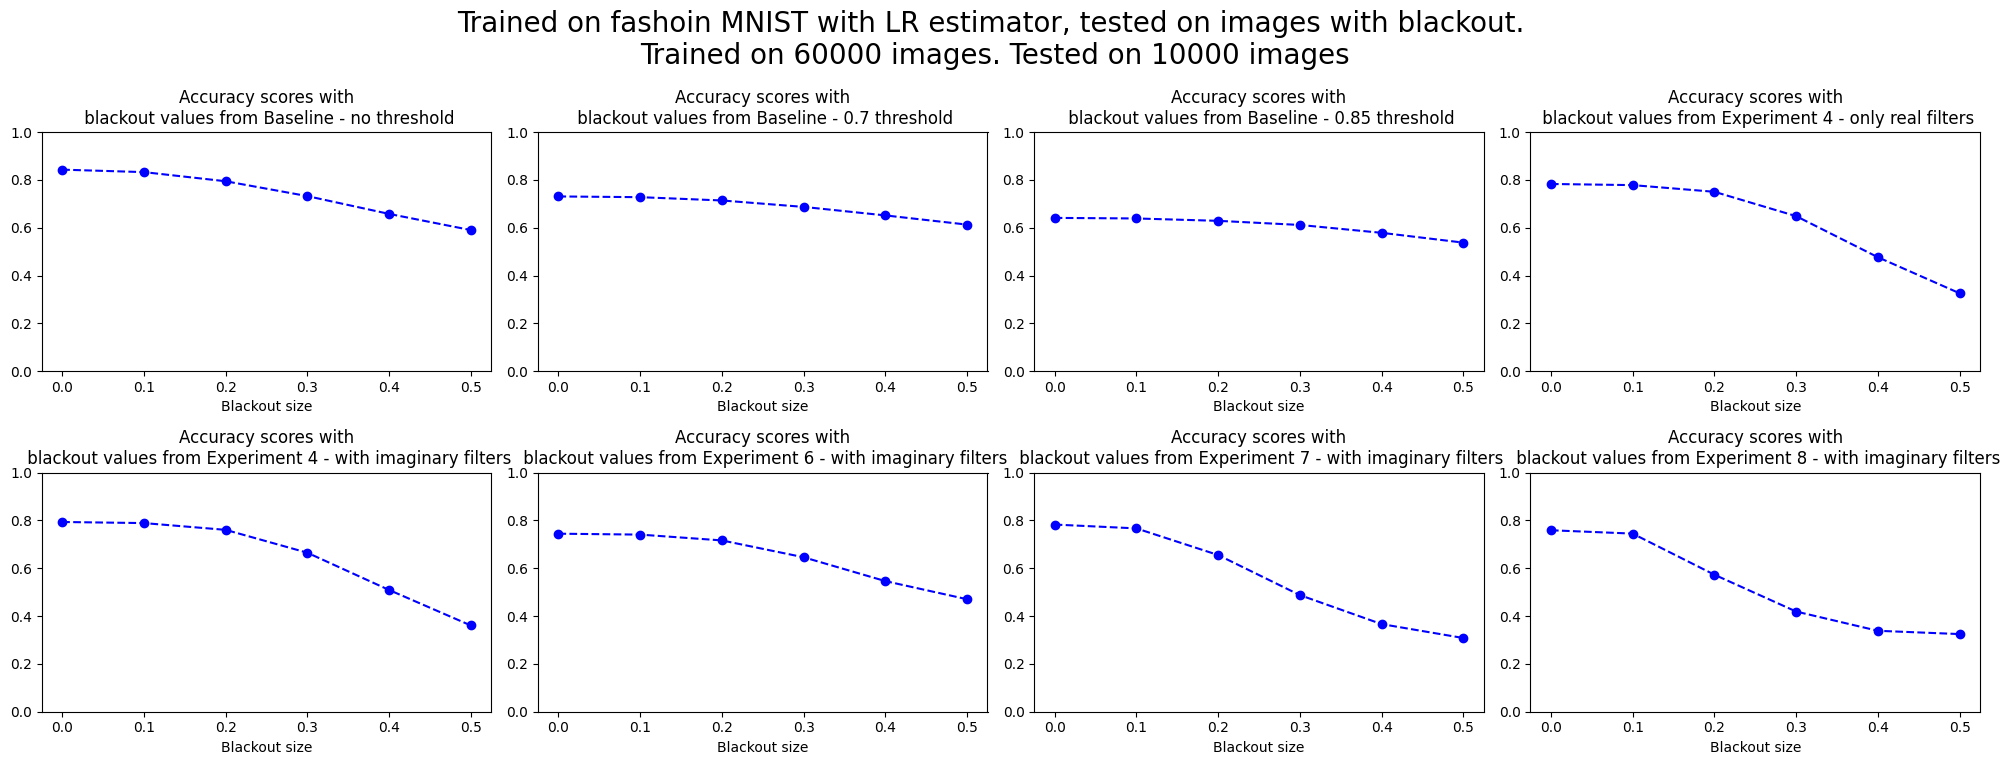

In [32]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in noises], scores_blackout_lr[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on fashoin MNIST with LR estimator, tested on images with blackout. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

## SVM

In [33]:
scores_blackout_svm = []

#### SVM - No thresholding

In [34]:
clfs_svm_blackout_bl = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm = score_clfs_noisy(clfs_svm_blackout_bl, train_flattened, y_train, blackout_test_flattened, y_test)
scores_blackout_svm.append(scores_blackout_baseline_svm)
scores_blackout_baseline_svm

[0.8694, 0.8634, 0.8295, 0.7488, 0.6787, 0.6522]

#### SVM - 0.7 threshold

In [35]:
clfs_svm_blackout_bl_thr1 = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm_thr1 = score_clfs_noisy(clfs_svm_blackout_bl_thr1,
                                                    train_flattened_blackout_threshold1, 
                                                    y_train, 
                                                    test_flattened_blackout_threshold1, 
                                                    y_test)

scores_blackout_svm.append(scores_blackout_baseline_svm_thr1)
scores_blackout_baseline_svm_thr1

[0.7682, 0.7627, 0.7467, 0.7118, 0.6633, 0.6276]

#### SVM - 0.85 threshold

In [36]:
clfs_svm_blackout_bl_thr2 = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm_thr2 = score_clfs_noisy(clfs_svm_blackout_bl_thr2,
                                                    train_flattened_blackout_threshold2, 
                                                    y_train, 
                                                    test_flattened_blackout_threshold2, 
                                                    y_test)

scores_blackout_svm.append(scores_blackout_baseline_svm_thr2)
scores_blackout_baseline_svm_thr2

[0.6606, 0.6559, 0.6429, 0.6179, 0.5722, 0.5289]

#### SVM - Experiment 4 - only real filters

In [37]:
clfs_svm_exp4_blackout = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp4_svm = score_clfs_noisy(clfs_svm_exp4_blackout, exp_4_train_transformed, y_train, exp_4_test_blackout_transformed, y_test)
scores_blackout_svm.append(scores_blackout_exp4_svm)
scores_blackout_exp4_svm

[0.7909, 0.7837, 0.7609, 0.6499, 0.4931, 0.3726]

#### SVM - Experiment 4 - with imaginary filters

In [38]:
clfs_svm_exp4_img_blackout = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp4_img_svm = score_clfs_noisy(clfs_svm_exp4_img_blackout, 
                                                exp_4_train_transformed_img, 
                                                y_train, 
                                                exp_4_img_test_blackout_transformed, 
                                                y_test)

scores_blackout_svm.append(scores_blackout_exp4_img_svm)
scores_blackout_exp4_img_svm

[0.7961, 0.7938, 0.7667, 0.6617, 0.5063, 0.3948]

#### SVM - Experiment 6

In [39]:
clfs_svm_exp6_img_blackout = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp6_img_svm = score_clfs_noisy(clfs_svm_exp6_img_blackout, 
                                                exp_6_train_transformed_img, 
                                                y_train, 
                                                exp_6_img_test_blackout_transformed, 
                                                y_test)

scores_blackout_svm.append(scores_blackout_exp6_img_svm)
scores_blackout_exp6_img_svm

[0.7667, 0.7643, 0.7325, 0.6327, 0.5411, 0.4962]

#### SVM - Experiment 7

In [40]:
clfs_svm_exp7_img_blackout = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp7_img_svm = score_clfs_noisy(clfs_svm_exp7_img_blackout, 
                                                exp_7_train_transformed_img, 
                                                y_train, 
                                                exp_7_img_test_blackout_transformed, 
                                                y_test)

scores_blackout_svm.append(scores_blackout_exp7_img_svm)
scores_blackout_exp7_img_svm

[0.7443, 0.7455, 0.6512, 0.4521, 0.3349, 0.2598]

#### SVM - Experiment 8

In [41]:
clfs_svm_exp8_img_blackout = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp8_img_svm = score_clfs_noisy(clfs_svm_exp8_img_blackout, 
                                                exp_8_train_transformed_img, 
                                                y_train, 
                                                exp_8_img_test_blackout_transformed, 
                                                y_test)

scores_blackout_svm.append(scores_blackout_exp8_img_svm)
scores_blackout_exp8_img_svm

[0.7352, 0.7354, 0.5828, 0.4083, 0.3134, 0.2561]

#### SVM Blackout results

Text(0.5, 0.98, 'Trained on fashoin MNIST with SVM estimator, tested on images with blackout. \nTrained on 60000 images. Tested on 10000 images')

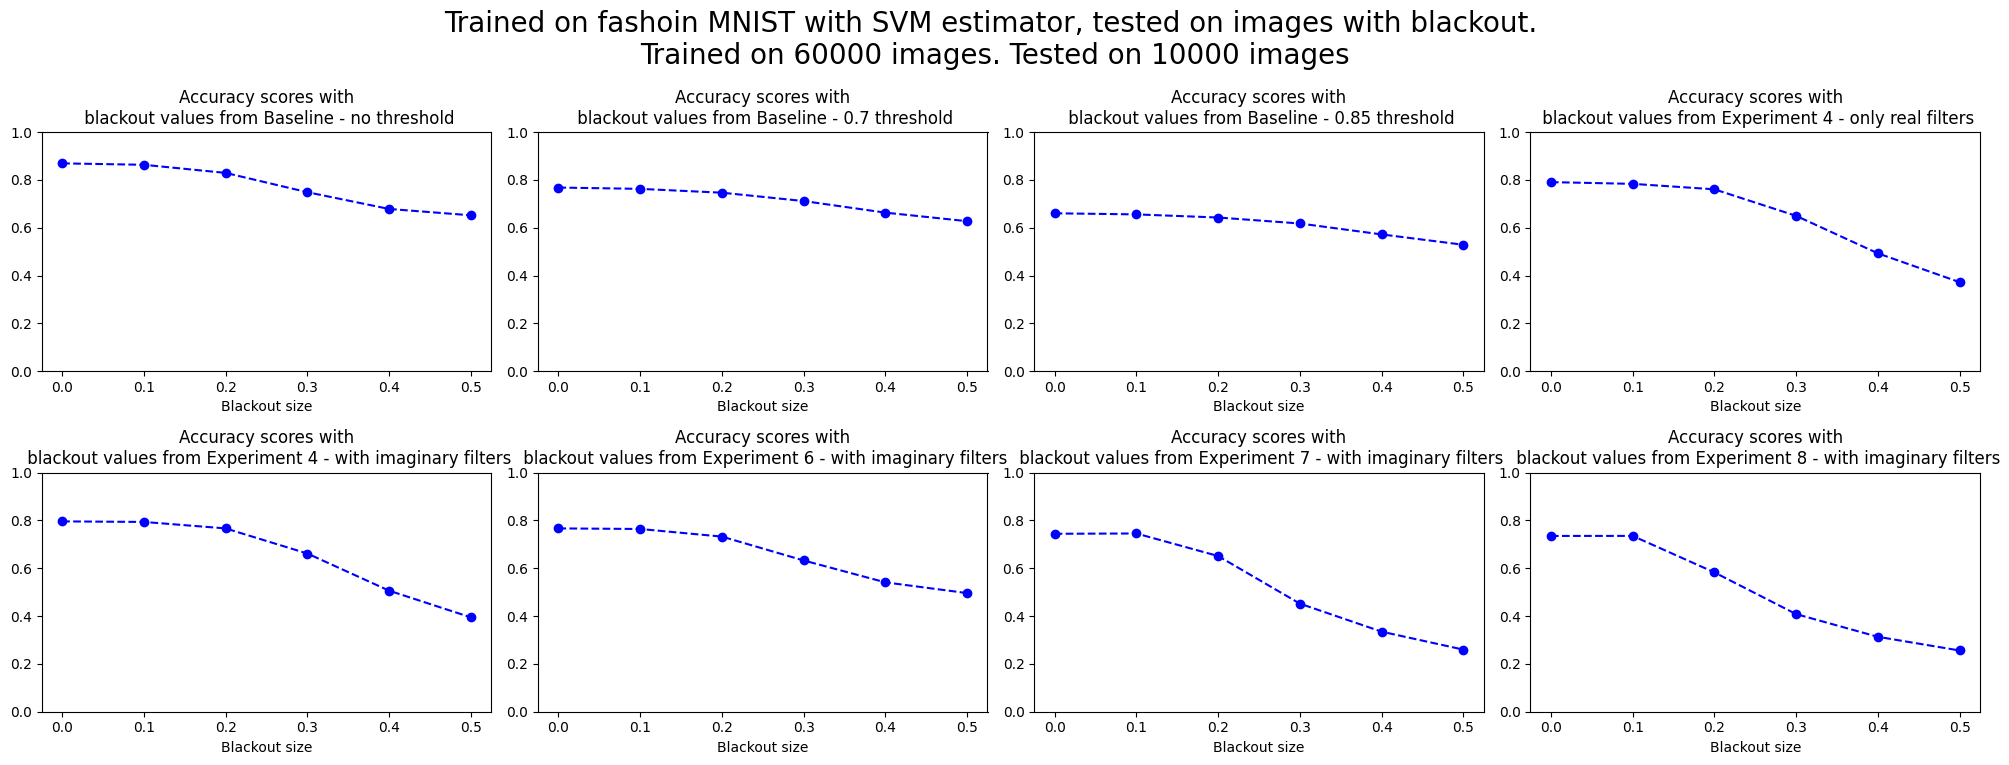

In [42]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in noises], scores_blackout_svm[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on fashoin MNIST with SVM estimator, tested on images with blackout. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### KNN

In [43]:
scores_blackout_knn = []

#### KNN - No thresholding

In [44]:
clfs_knn_blackout_bl = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_blackout = score_clfs_noisy(clfs_knn_blackout_bl, train_flattened, y_train, blackout_test_flattened, y_test)
scores_blackout_knn.append(baseline_knn_scores_blackout)
baseline_knn_scores_blackout

[0.8533, 0.8486, 0.8386, 0.7972, 0.6936, 0.5781]

#### KNN - 0.7 thresholding

In [45]:
clfs_knn_blackout_bl_thr1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr1 = score_clfs_noisy(clfs_knn_blackout_bl_thr1, 
                                       train_flattened_blackout_threshold1, 
                                       y_train, 
                                       test_flattened_blackout_threshold1, 
                                       y_test)

scores_blackout_knn.append(baseline_knn_scores_thr1)
baseline_knn_scores_thr1

[0.7145, 0.7106, 0.6941, 0.6444, 0.5527, 0.4695]

#### KNN - 0.85 thresholding

In [46]:
clfs_knn_blackout_bl_thr2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]

baseline_knn_scores_thr2 = score_clfs_noisy(clfs_knn_blackout_bl_thr2, 
                                       train_flattened_blackout_threshold2, 
                                       y_train, 
                                       test_flattened_blackout_threshold2, 
                                       y_test)

scores_blackout_knn.append(baseline_knn_scores_thr2)
baseline_knn_scores_thr2

[0.5823, 0.5812, 0.5634, 0.5328, 0.4779, 0.412]

#### KNN - Experiment 4 - only real filters

In [47]:
clfs_knn_exp4_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp4_knn = score_clfs_noisy(clfs_knn_exp4_blackout, 
                                            exp_4_train_transformed, 
                                            y_train, 
                                            exp_4_test_blackout_transformed, 
                                            y_test)

scores_blackout_knn.append(scores_blackout_exp4_knn)
scores_blackout_exp4_knn

[0.8218, 0.8102, 0.7645, 0.6599, 0.5153, 0.3944]

#### KNN - Experiment 4 - with imaginary filters

In [48]:
clfs_knn_exp4_img_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp4_img_knn = score_clfs_noisy(clfs_knn_exp4_img_blackout, 
                                                exp_4_train_transformed_img, 
                                                y_train, 
                                                 exp_4_img_test_blackout_transformed, 
                                                 y_test)

scores_blackout_knn.append(scores_blackout_exp4_img_knn)
scores_blackout_exp4_img_knn

[0.8248, 0.8102, 0.7736, 0.6634, 0.5202, 0.3959]

#### KNN - Experiment 6

In [49]:
clfs_knn_exp6_img_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp6_img_knn = score_clfs_noisy(clfs_knn_exp6_img_blackout, 
                                                  exp_6_train_transformed_img, 
                                                  y_train, 
                                                  exp_6_img_test_blackout_transformed, 
                                                  y_test)

scores_blackout_knn.append(scores_blackout_exp6_img_knn)
scores_blackout_exp6_img_knn

[0.7643, 0.7486, 0.7105, 0.6276, 0.5425, 0.4232]

#### KNN - Experiment 7

In [50]:
clfs_knn_exp7_img_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp7_img_knn = score_clfs_noisy(clfs_knn_exp7_img_blackout, 
                                                exp_7_train_transformed_img, 
                                                y_train, 
                                                exp_7_img_test_blackout_transformed, 
                                                y_test)

scores_blackout_knn.append(scores_blackout_exp7_img_knn)
scores_blackout_exp7_img_knn

[0.7911, 0.7483, 0.5927, 0.351, 0.2343, 0.1582]

#### KNN - Experiment 8

In [51]:
clfs_knn_exp8_img_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp8_img_knn = score_clfs_noisy(clfs_knn_exp8_img_blackout, 
                                                exp_8_train_transformed_img, 
                                                y_train, 
                                                exp_8_img_test_blackout_transformed, 
                                                y_test)

scores_blackout_knn.append(scores_blackout_exp8_img_knn)
scores_blackout_exp8_img_knn

[0.7761, 0.7307, 0.5459, 0.3358, 0.237, 0.163]

#### KNN Blackout results

Text(0.5, 0.98, 'Trained on fashoin MNIST with KNN estimator, tested on images with blackout. \nTrained on 60000 images. Tested on 10000 images')

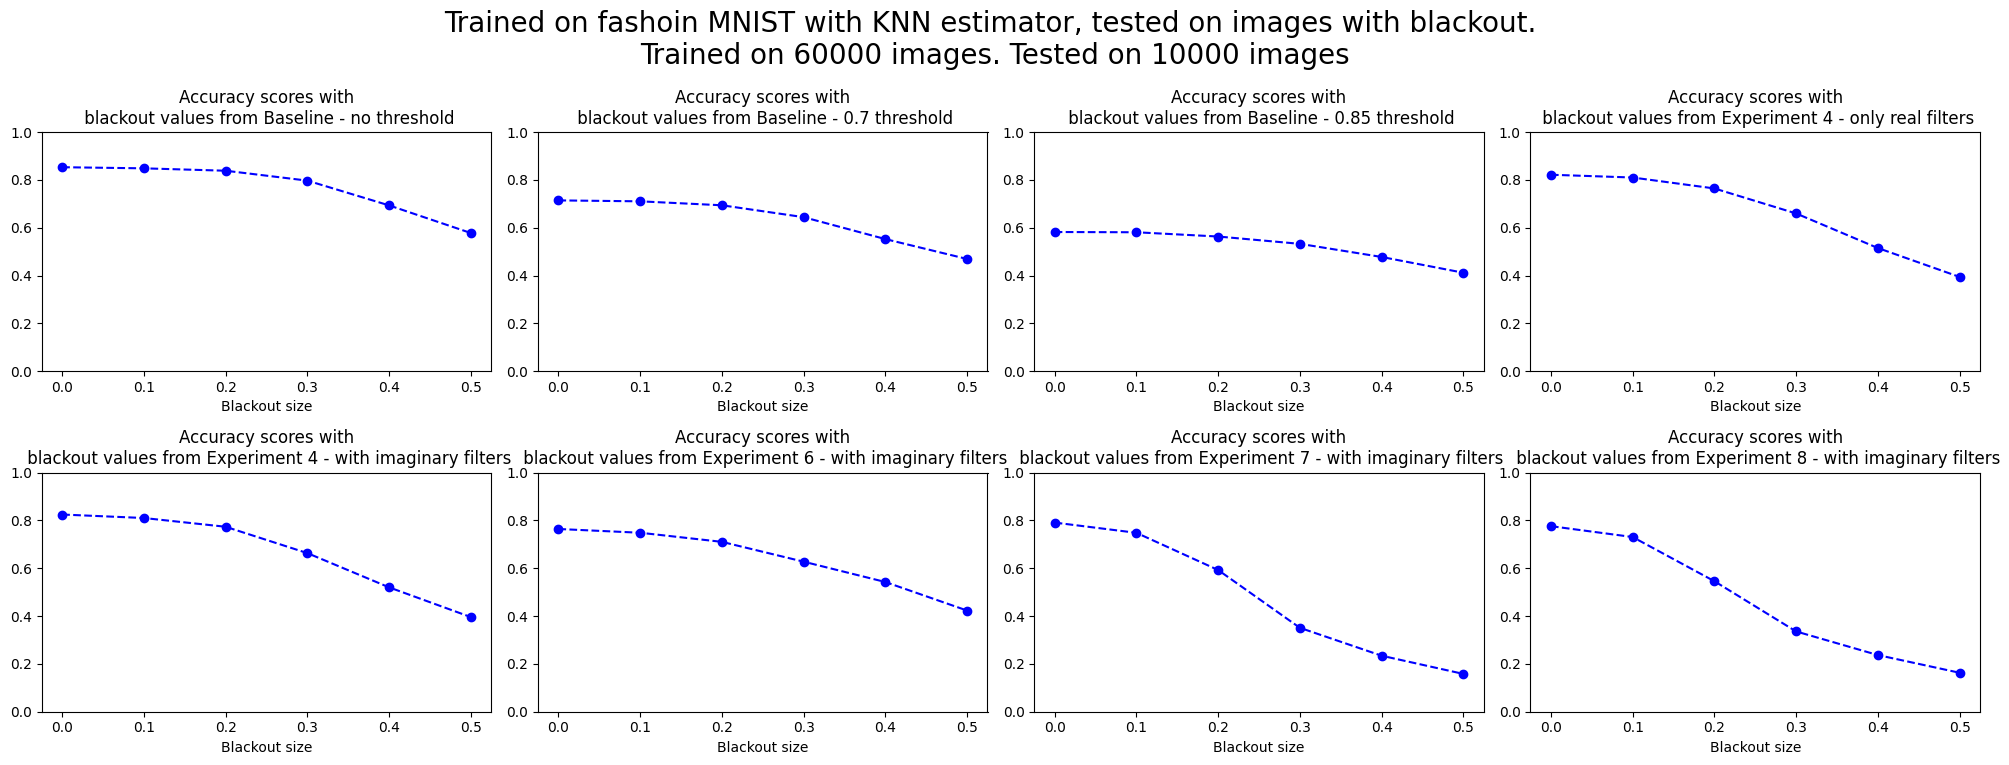

In [53]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in noises], scores_blackout_knn[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on fashoin MNIST with KNN estimator, tested on images with blackout. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### CNN

#### Noise

In [35]:
cnn_scores_noise = []
cnn_blackout_scores_noise = []

In [20]:
from tensorflow.keras import layers

In [21]:
mnist_train_pixelshape = [np.expand_dims(data, -1) for data in data_train]
mnist_test_pixelshape = [np.expand_dims(data, -1) for data in data_test]

In [22]:
input_shape = mnist_train_pixelshape[0].shape[-3:]
classes = np.unique(y_train).shape[0]

In [23]:
classes

10

In [24]:
train_labels_binary = keras.utils.to_categorical(y_train, classes)
test_labels_binary = keras.utils.to_categorical(y_test, classes)

In [30]:
def make_model_baseline(input_shape, num_classes):
    return keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

cnn_noises = [.0, .1, .2, .3, .4, .5]

def add_noise(std, img, shape):
    noi = np.random.normal(.0, std, size=shape)
    return img + noi[..., np.newaxis]


def score_cnn(clfs, X_train, y_train, X_test, y_test):
    scores = []
    batch_size = 128
    epochs = 15
    X_tr = np.array(X_train)

    for i, clf in enumerate(clfs):
        X_te = np.array([add_noise(cnn_noises[i], img, (27, 27)) for img in X_test])
        clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        clf.fit(X_tr, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        scores.append(clf.evaluate(X_te, y_test, verbose=0)[1])
    return scores

def score_cnn_bl(clfs, X_train, y_train, X_test, y_test):
    scores = []
    batch_size = 128
    epochs = 15
    X_tr = np.array(X_train)

    for i, clf in enumerate(clfs):
        X_te = np.array([black_out_section(img, blackout_sizes[i]) for img in X_test])
        clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        clf.fit(X_tr, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        scores.append(clf.evaluate(X_te, y_test, verbose=0)[1])
    return scores

In [38]:
clfs_bl_cnn = [make_model_baseline(input_shape=input_shape, num_classes=classes) for _ in range(len(cnn_noises))]
cnn_scores_noise.append(score_cnn(clfs_bl_cnn, mnist_train_pixelshape, train_labels_binary, mnist_test_pixelshape, test_labels_binary))

In [36]:
clfs_blackout_bl_cnn = [make_model_baseline(input_shape=input_shape, num_classes=classes) for _ in range(len(blackout_sizes))]
cnn_blackout_scores_noise.append(score_cnn_bl(clfs_blackout_bl_cnn, mnist_train_pixelshape, train_labels_binary, mnist_test_pixelshape, test_labels_binary))

In [39]:
print(cnn_scores_noise)
cnn_blackout_scores_noise

[[0.9052000045776367, 0.8476999998092651, 0.6194000244140625, 0.5457000136375427, 0.5674999952316284, 0.4092000126838684]]


[[0.9020000100135803,
  0.8709999918937683,
  0.7965999841690063,
  0.6247000098228455,
  0.49549999833106995,
  0.4453999996185303]]

Text(0.5, 1.0, 'CNN accuracy scores with blackout values from baseline')

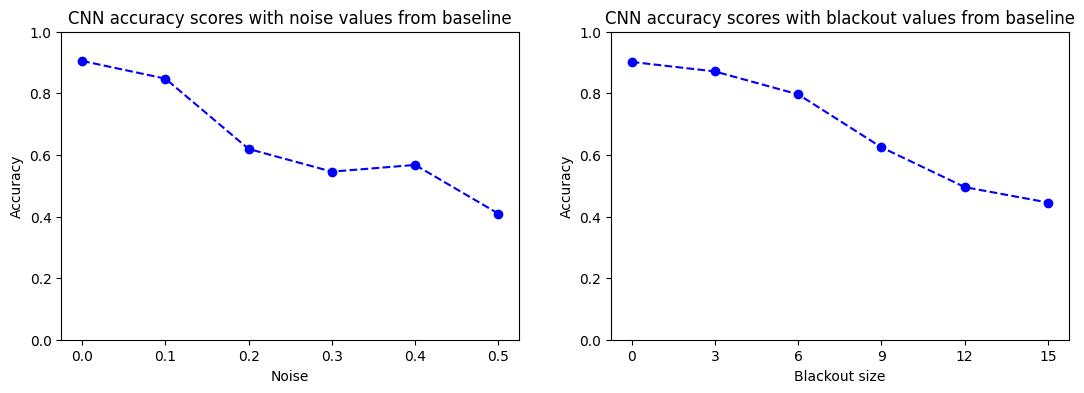

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].plot([str(t) for t in cnn_noises], cnn_scores_noise[0], linestyle='--', marker='o', color='b', label='Accuracy score')
ax[0].set_ylim([.0, 1.])
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Noise")
ax[0].set_title("CNN accuracy scores with noise values from baseline")
ax[1].plot([str(t) for t in blackout_sizes], cnn_blackout_scores_noise[0], linestyle='--', marker='o', color='b', label='Accuracy score')
ax[1].set_ylim([.0, 1.])
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Blackout size")
ax[1].set_title("CNN accuracy scores with blackout values from baseline")

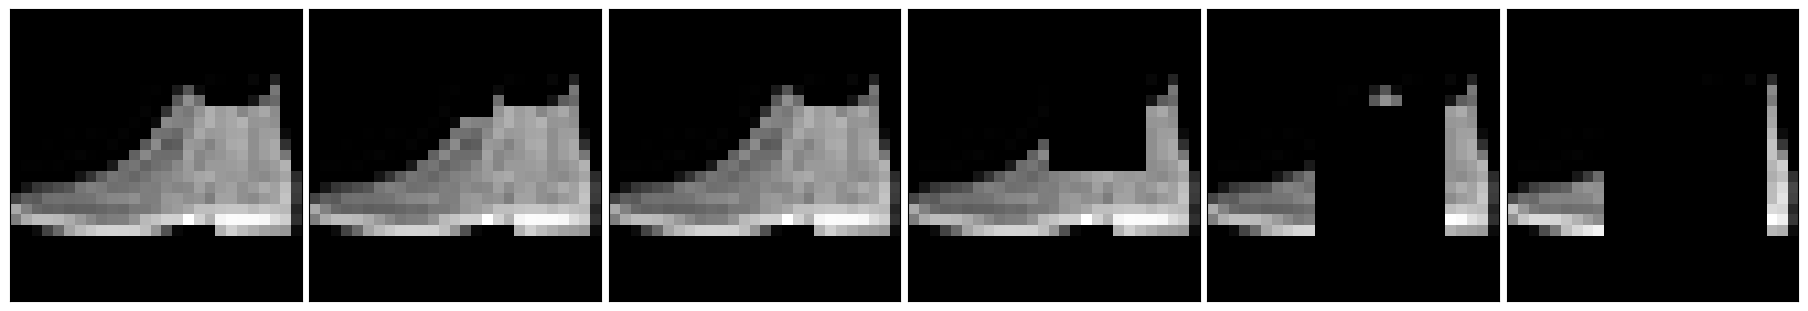

In [78]:
fig, ax = plt.subplots(1, len(blackout_sizes), figsize=(18, 3))
for i in range(len(blackout_sizes)): 
    ax[i].imshow(blackout_tests[i][0], cmap="gray")
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    #ax[i].set_title(f"Reference image with blackout with size {blackout_sizes[i]}")
plt.tight_layout(pad=0.3)

### Inverted test set

In [11]:
inverted_test = np.array([img * -1 for img in data_test])

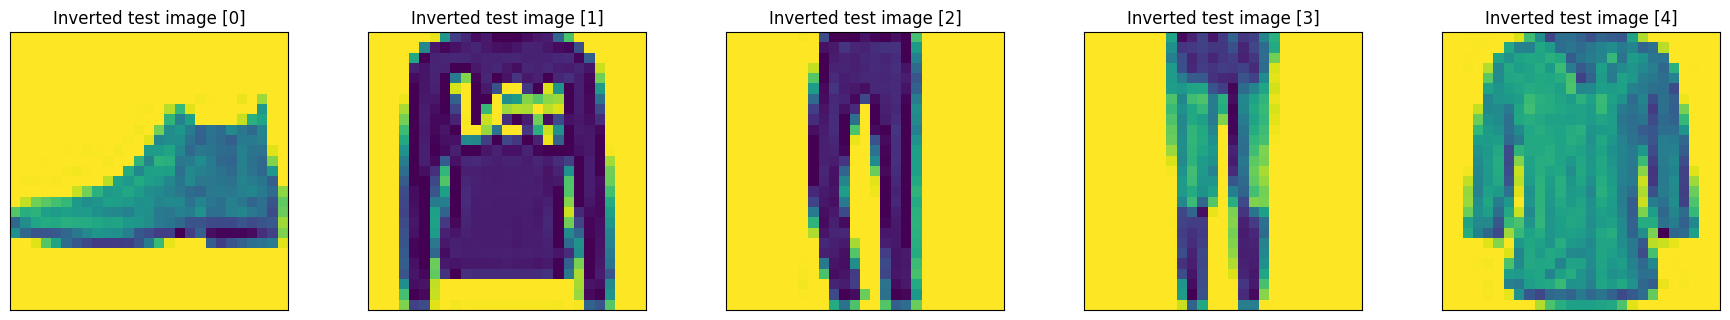

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3))
for i in range(5): 
    ax[i].imshow(inverted_test[i])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Inverted test image {[i]}")
plt.tight_layout(pad=0.0)

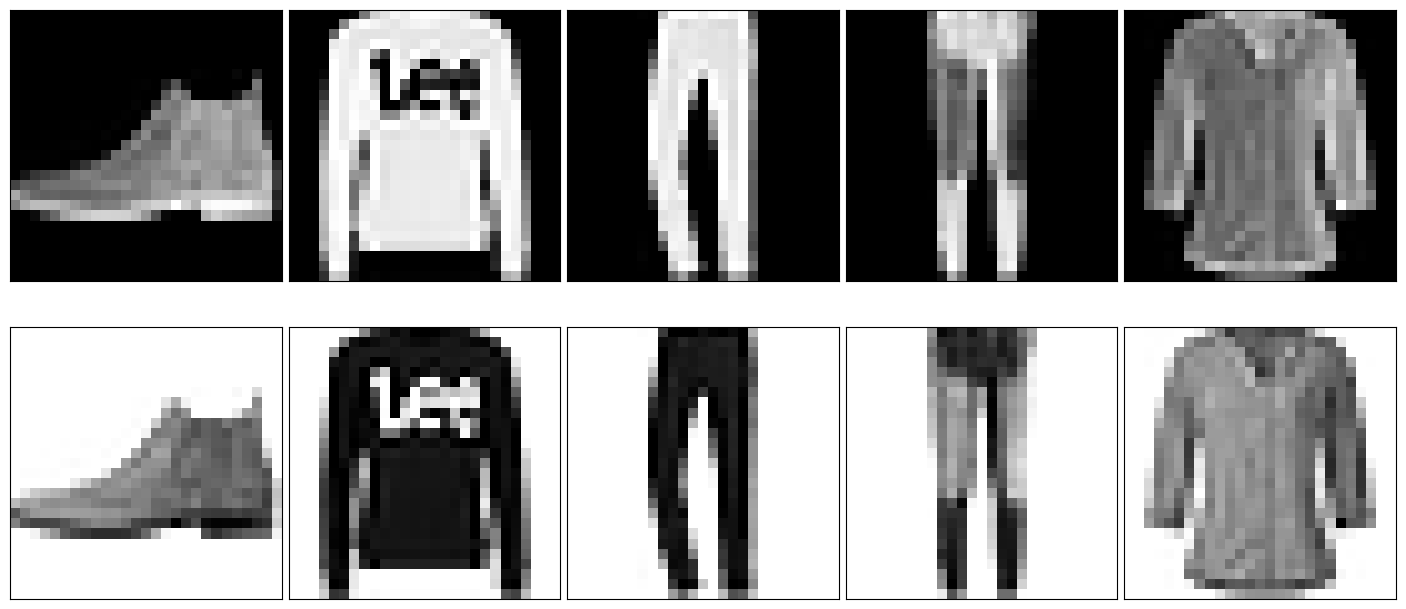

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(14, 7))
for i in range(10): 
    if i < 5:
        ax[0][i].imshow(data_test[i], cmap="gray")
        ax[0][i].set_xticks(())
        ax[0][i].set_yticks(())
    else:
        ax[1][i-5].imshow(inverted_test[i-5], cmap="gray")
        ax[1][i-5].set_xticks(())
        ax[1][i-5].set_yticks(())
    #ax[i].set_title(f"Reference image with noise {noises[i]}")
plt.tight_layout(pad=0.5)

In [20]:
inv_test_flattened = np.array([data.reshape(27*27) for data in inverted_test])
test_flattened = np.array([data.reshape(27*27) for data in data_test])
scores_inv = []
scores_not_inv = []

In [21]:
def score_inv_clf(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    return clf.score(x_test, y_test)

In [22]:
clfs_bl_lr = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=64,
                                     tol=0.01)

scores_baseline_lr = score_inv_clf(clfs_bl_lr, train_flattened, y_train, test_flattened, y_test)
scores_not_inv.append(scores_baseline_lr)
scores_baseline_lr

0.8431

In [23]:
clfs_inv_bl_lr = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=64,
                                     tol=0.01)

scores_inv_baseline_lr = score_inv_clf(clfs_inv_bl_lr, train_flattened, y_train, inv_test_flattened, y_test)
scores_inv.append(scores_inv_baseline_lr)
scores_inv_baseline_lr

0.0054

In [24]:
train_flattened_inv_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
test_flattened_inv_threshold1 = np.where(inv_test_flattened > 0.7, inv_test_flattened, 0.)
train_flattened_inv_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
test_flattened_inv_threshold2 = np.where(inv_test_flattened > 0.85, inv_test_flattened, 0.)

test_flattened_threshold1 = np.where(test_flattened > 0.7, test_flattened, 0.)
test_flattened_threshold2 = np.where(test_flattened > 0.85, test_flattened, 0.)

#### 0.7

In [25]:
clfs_bl_lr_thr1 = LogisticRegression(fit_intercept=True,
                                          multi_class='multinomial',
                                          penalty='l2',
                                          solver='saga',
                                          max_iter=1000,
                                          n_jobs=64,
                                          tol=0.01)

score_baseline_lr_thr1 = score_inv_clf(clfs_bl_lr_thr1, 
                                        train_flattened_inv_threshold1, 
                                        y_train, 
                                        test_flattened_threshold1, 
                                        y_test)

scores_not_inv.append(score_baseline_lr_thr1)
score_baseline_lr_thr1

0.7311

In [26]:
clfs_inv_bl_lr_thr1 = LogisticRegression(fit_intercept=True,
                                          multi_class='multinomial',
                                          penalty='l2',
                                          solver='saga',
                                          max_iter=1000,
                                          n_jobs=64,
                                          tol=0.01)

scores_inv_baseline_lr_thr1 = score_inv_clf(clfs_inv_bl_lr_thr1, 
                                            train_flattened_inv_threshold1, 
                                            y_train, 
                                            test_flattened_inv_threshold1, 
                                            y_test)

scores_inv.append(scores_inv_baseline_lr_thr1)
scores_inv_baseline_lr_thr1

0.1

#### 0.85

In [27]:
clfs_bl_lr_thr2 = LogisticRegression(fit_intercept=True,
                                          multi_class='multinomial',
                                          penalty='l2',
                                          solver='saga',
                                          max_iter=1000,
                                          n_jobs=64,
                                          tol=0.01)

score_baseline_lr_thr2 = score_inv_clf(clfs_bl_lr_thr2, 
                                        train_flattened_inv_threshold2, 
                                        y_train, 
                                        test_flattened_threshold2, 
                                        y_test)

scores_not_inv.append(score_baseline_lr_thr2)
score_baseline_lr_thr2

0.641

In [28]:
clfs_inv_bl_lr_thr2 = LogisticRegression(fit_intercept=True,
                                          multi_class='multinomial',
                                          penalty='l2',
                                          solver='saga',
                                          max_iter=1000,
                                          n_jobs=64,
                                          tol=0.01)

scores_inv_baseline_lr_thr2 = score_inv_clf(clfs_inv_bl_lr_thr2, 
                                            train_flattened_inv_threshold2, 
                                            y_train, 
                                            test_flattened_inv_threshold2, 
                                            y_test)

scores_inv.append(scores_inv_baseline_lr_thr2)
scores_inv_baseline_lr_thr2

0.1

#### ex4

In [29]:
from components.cnn_parallell import experiment4_img_neg, experiment6_img_neg, experiment7_img_neg, experiment8_img_neg

In [30]:
exp4_train_img_inv = experiment4_img_neg(data_train)
exp_4_test_inv_transformed = experiment4_img_neg(inverted_test)
exp4_test_transformed = experiment4_img_neg(data_test)

""" exp4_train_img_inv = load_coefficients("train", "experiment_4_img_neg")
exp_4_test_inv_transformed = load_coefficients("test/experiment4_img_neg", "experiment4_inv_test")

exp4_test_transformed = experiment4_img_neg(data_test) """

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

' exp4_train_img_inv = load_coefficients("train", "experiment_4_img_neg")\nexp_4_test_inv_transformed = load_coefficients("test/experiment4_img_neg", "experiment4_inv_test")\n\nexp4_test_transformed = experiment4_img_neg(data_test) '

In [31]:
exp6_train_img_inv = experiment6_img_neg(data_train, threshold=0.85)
exp_6_test_inv_transformed = experiment6_img_neg(inverted_test, threshold=0.85)
exp6_test_transformed = experiment6_img_neg(data_test, threshold=0.85)

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [32]:
exp7_train_img_inv = experiment7_img_neg(data_train, grids=[(3, 3), (2, 5), (1, 7)])
exp_7_test_inv_transformed = experiment7_img_neg(inverted_test, grids=[(3, 3), (2, 5), (1, 7)])
exp7_test_transformed = experiment7_img_neg(data_test, grids=[(3, 3), (2, 5), (1, 7)])

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [33]:
exp8_train_img_inv = experiment8_img_neg(data_train, grids=[(3, 3), (2, 5), (1, 7)], threshold=0.7)
exp_8_test_inv_transformed = experiment8_img_neg(inverted_test, grids=[(3, 3), (2, 5), (1, 7)], threshold=0.7)
exp8_test_transformed = experiment8_img_neg(data_test, grids=[(3, 3), (2, 5), (1, 7)], threshold=0.7)

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [34]:
save_coefficients("train", exp4_train_img_inv, "experiment_4_img_neg_fashion_mnist")
save_coefficients("test/experiment4_img_neg", exp_4_test_inv_transformed, "experiment4_inv_test_fashion_mnist")
save_coefficients("test/experiment4_img_neg", exp4_test_transformed, "experiment4_test_fashion_mnist")

save_coefficients("train", exp6_train_img_inv, "experiment_6_img_neg_fashion_mnist")
save_coefficients("test/experiment6_img_neg", exp_6_test_inv_transformed, "experiment6_inv_test_fashion_mnist")
save_coefficients("test/experiment6_img_neg", exp6_test_transformed, "experiment6_test_fashion_mnist")

save_coefficients("train", exp7_train_img_inv, "experiment_7_img_neg_fashion_mnist")
save_coefficients("test/experiment7_img_neg", exp_7_test_inv_transformed, "experiment7_inv_test_fashion_mnist")
save_coefficients("test/experiment7_img_neg", exp7_test_transformed, "experiment7_test_fashion_mnist")

save_coefficients("train", exp7_train_img_inv, "experiment_7_img_neg_fashion_mnist")
save_coefficients("test/experiment7_img_neg", exp_7_test_inv_transformed, "experiment7_inv_test_fashion_mnist")
save_coefficients("test/experiment7_img_neg", exp7_test_transformed, "experiment7_test_fashion_mnist")


coefficients/train/experiment_4_img_neg_fashion_mnist.npy saved
coefficients/test/experiment4_img_neg/experiment4_inv_test_fashion_mnist.npy saved
coefficients/test/experiment4_img_neg/experiment4_test_fashion_mnist.npy saved
coefficients/train/experiment_6_img_neg_fashion_mnist.npy saved
coefficients/test/experiment6_img_neg/experiment6_inv_test_fashion_mnist.npy saved
coefficients/test/experiment6_img_neg/experiment6_test_fashion_mnist.npy saved
coefficients/train/experiment_7_img_neg_fashion_mnist.npy saved
coefficients/test/experiment7_img_neg/experiment7_inv_test_fashion_mnist.npy saved
coefficients/test/experiment7_img_neg/experiment7_test_fashion_mnist.npy saved
coefficients/train/experiment_7_img_neg_fashion_mnist.npy saved
coefficients/test/experiment7_img_neg/experiment7_inv_test_fashion_mnist.npy saved
coefficients/test/experiment7_img_neg/experiment7_test_fashion_mnist.npy saved


#### 4

In [35]:
clfs_lr_ex4 = LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=0.01) 

score_exp4_lr = score_inv_clf(clfs_lr_ex4, 
                              exp4_train_img_inv, 
                              y_train, 
                              exp4_test_transformed, 
                              y_test)

scores_not_inv.append(score_exp4_lr)
score_exp4_lr

0.7932

In [36]:
clfs_lr_ex4_inv = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=0.01) 

scores_inv_exp4_lr = score_inv_clf(clfs_lr_ex4_inv, 
                                   exp4_train_img_inv, 
                                   y_train, 
                                   exp_4_test_inv_transformed, 
                                   y_test)

scores_inv.append(scores_inv_exp4_lr)
scores_inv_exp4_lr

0.793

#### 6

In [37]:
clfs_lr_ex6 = LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=0.01) 

score_exp6_lr = score_inv_clf(clfs_lr_ex6, 
                              exp6_train_img_inv, 
                              y_train, 
                              exp6_test_transformed, 
                              y_test)

scores_not_inv.append(score_exp6_lr)
score_exp6_lr

0.7442

In [38]:
clfs_lr_ex6_inv = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=0.01) 

scores_inv_exp6_lr = score_inv_clf(clfs_lr_ex6_inv, 
                                   exp6_train_img_inv, 
                                   y_train, 
                                   exp_6_test_inv_transformed, 
                                   y_test)

scores_inv.append(scores_inv_exp6_lr)
scores_inv_exp6_lr

0.7446

#### 7

In [39]:
clfs_lr_ex7 = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=0.01) 

score_exp7_lr = score_inv_clf(clfs_lr_ex7, 
                              exp7_train_img_inv, 
                              y_train, 
                              exp7_test_transformed, 
                              y_test)

scores_not_inv.append(score_exp7_lr)
score_exp7_lr

0.7703

In [40]:
clfs_lr_ex7_inv = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=0.01) 

scores_inv_exp7_lr = score_inv_clf(clfs_lr_ex7_inv, 
                                   exp7_train_img_inv, 
                                   y_train, 
                                   exp_7_test_inv_transformed, 
                                   y_test)

scores_inv.append(scores_inv_exp7_lr)
scores_inv_exp7_lr

0.7704

#### 8

In [41]:
clfs_lr_ex8 = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=0.01) 

score_exp8_lr = score_inv_clf(clfs_lr_ex8, 
                              exp8_train_img_inv, 
                              y_train, 
                              exp8_test_transformed, 
                              y_test)

scores_not_inv.append(score_exp8_lr)
score_exp8_lr

0.7449

In [42]:
clfs_lr_ex8_inv = LogisticRegression(fit_intercept=True,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     n_jobs=8,
                                     tol=0.01) 

scores_inv_exp8_lr = score_inv_clf(clfs_lr_ex8_inv, 
                                   exp8_train_img_inv, 
                                   y_train, 
                                   exp_8_test_inv_transformed, 
                                   y_test)

scores_inv.append(scores_inv_exp8_lr)
scores_inv_exp8_lr

0.7448

In [18]:
exps = [
    "Baseline - no threshold",
    "Baseline - 0.7 threshold",
    "Baseline - 0.85 threshold",
    "Experiment 4",
    "Experiment 6",
    "Experiment 7",
    "Experiment 8"
]

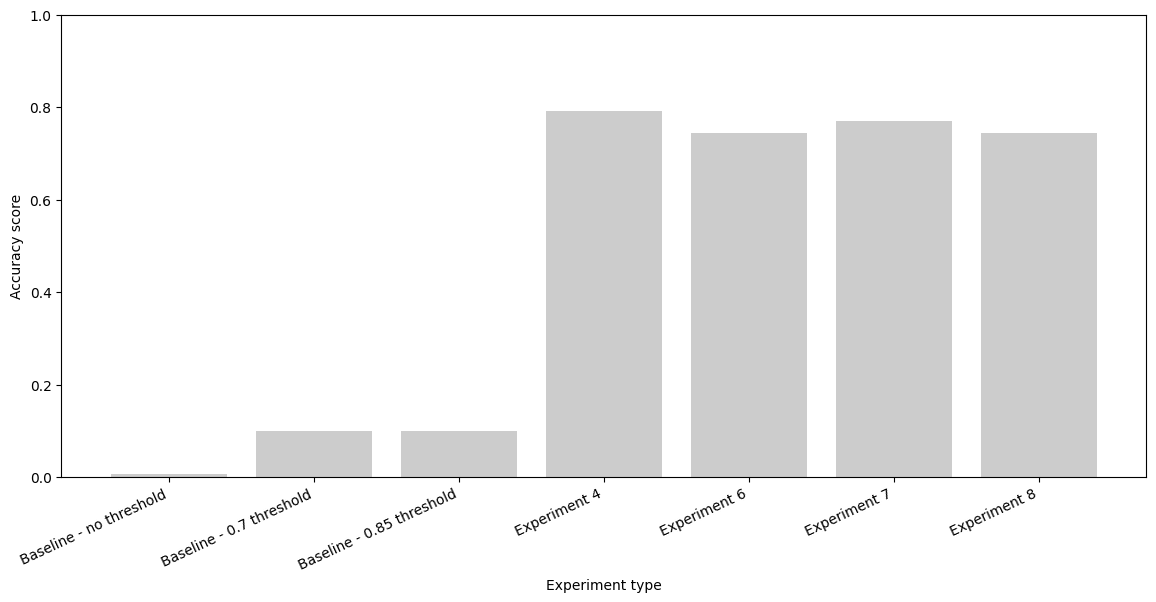

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Baseline - no threshold'),
  Text(1, 0, 'Baseline - 0.7 threshold'),
  Text(2, 0, 'Baseline - 0.85 threshold'),
  Text(3, 0, 'Experiment 4'),
  Text(4, 0, 'Experiment 6'),
  Text(5, 0, 'Experiment 7'),
  Text(6, 0, 'Experiment 8')])

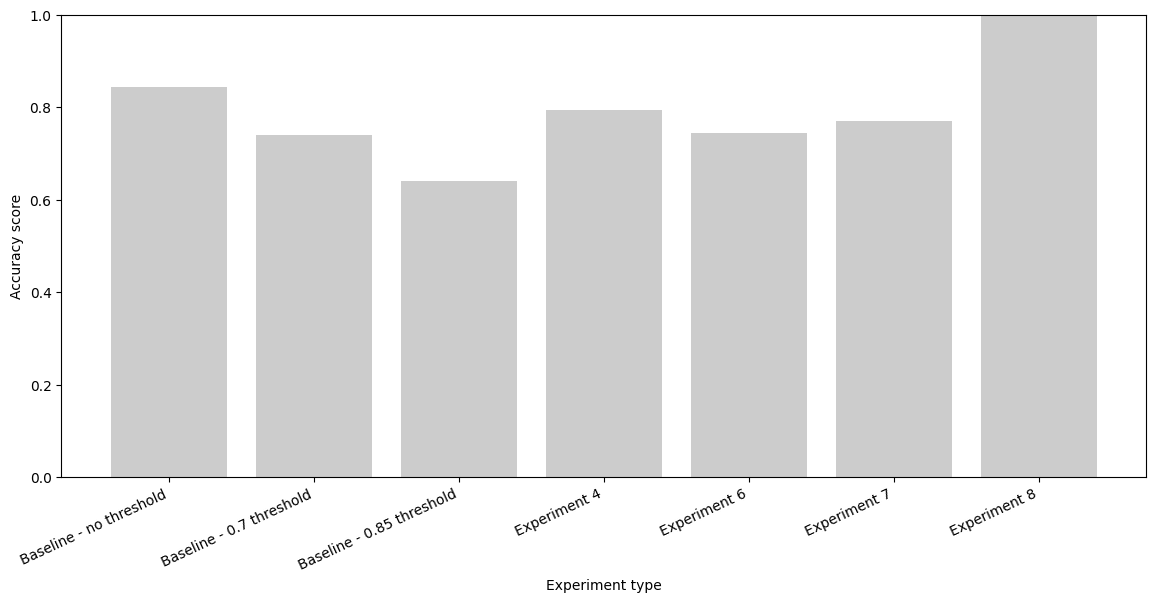

In [19]:
plt.rcParams["figure.figsize"] = (14,6)
plt.bar(exps, scores_inv, color='0.8')
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score")
plt.xticks(rotation=25, ha='right')
plt.show()
plt.bar(exps, scores_not_inv, color='0.8')
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score")
plt.xticks(rotation=25, ha='right')

In [45]:
scores_inv_svm = []
scores_not_inv_svm = []

svm_best_Cs = {
    "baseline": 10.,
    "exp1": 500.,
    "exp2": 500.,
    "exp3": 500.,
    "exp4": 500.,
    "exp5": 500.,
    "exp6": 10.,
    "exp7": 10.,
    "exp8": 10.
}

In [46]:
clfs_svm_bl = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

score_baseline_svm = score_inv_clf(clfs_svm_bl, 
                                    train_flattened, 
                                    y_train, 
                                    test_flattened, 
                                    y_test)

scores_not_inv_svm.append(score_baseline_svm)
score_baseline_svm


0.8694

In [47]:
clfs_svm_inv_bl = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

score_inv_baseline_svm = score_inv_clf(clfs_svm_inv_bl, 
                                       train_flattened, 
                                       y_train, 
                                       inv_test_flattened, 
                                       y_test)

scores_inv_svm.append(score_inv_baseline_svm)
score_inv_baseline_svm

0.0351

#### b - 0.7

In [48]:
clfs_svm_bl_thr1 = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

score_baseline_svm_thr1 = score_inv_clf(clfs_svm_bl_thr1, 
                                        train_flattened_inv_threshold1, 
                                        y_train, 
                                        test_flattened_threshold1, 
                                        y_test)

scores_not_inv_svm.append(score_baseline_svm_thr1)
score_baseline_svm_thr1

0.7684

In [49]:
clfs_svm_inv_bl_thr1 = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

scores_inv_baseline_svm_thr1 = score_inv_clf(clfs_svm_inv_bl_thr1, 
                                            train_flattened_inv_threshold1, 
                                            y_train, 
                                            test_flattened_inv_threshold1, 
                                            y_test)

scores_inv_svm.append(scores_inv_baseline_svm_thr1)
scores_inv_baseline_svm_thr1

0.1

#### b - 0.85

In [50]:
clfs_svm_bl_thr2 = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

score_baseline_svm_thr2 = score_inv_clf(clfs_svm_bl_thr2, 
                                        train_flattened_inv_threshold2, 
                                        y_train, 
                                        test_flattened_threshold2, 
                                        y_test)

scores_not_inv_svm.append(score_baseline_svm_thr2)
score_baseline_svm_thr2

0.6606

In [51]:
clfs_svm_inv_bl_thr2 = SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto")

scores_inv_baseline_svm_thr2 = score_inv_clf(clfs_svm_inv_bl_thr2, 
                                            train_flattened_inv_threshold2, 
                                            y_train, 
                                            test_flattened_inv_threshold2, 
                                            y_test)

scores_inv_svm.append(scores_inv_baseline_svm_thr2)
scores_inv_baseline_svm_thr2

0.1

#### 4

In [52]:
clfs_svm_exp4 = SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto")

score_exp4_svm = score_inv_clf(clfs_svm_exp4, 
                                exp4_train_img_inv, 
                                y_train, 
                                exp4_test_transformed, 
                                y_test)

scores_not_inv_svm.append(score_exp4_svm)
score_exp4_svm

0.8426

In [53]:
clfs_svm_exp4_inv = SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto")

scores_inv_exp4_svm = score_inv_clf(clfs_svm_exp4_inv, 
                                    exp4_train_img_inv, 
                                    y_train, 
                                    exp_4_test_inv_transformed, 
                                    y_test)

scores_inv_svm.append(scores_inv_exp4_svm)
scores_inv_exp4_svm

0.8426

#### 6

In [54]:
clfs_svm_exp6 = SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto")

score_exp6_svm = score_inv_clf(clfs_svm_exp6, 
                                exp6_train_img_inv, 
                                y_train, 
                                exp6_test_transformed, 
                                y_test)

scores_not_inv_svm.append(score_exp6_svm)
score_exp6_svm

0.7667

In [55]:
clfs_svm_exp6_inv = SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto")

scores_inv_exp6_svm = score_inv_clf(clfs_svm_exp6_inv, 
                                    exp6_train_img_inv, 
                                    y_train, 
                                    exp_6_test_inv_transformed, 
                                    y_test)

scores_inv_svm.append(scores_inv_exp6_svm)
scores_inv_exp6_svm

0.7667

#### 7

In [56]:
clfs_svm_exp7 = SVC(kernel='rbf', C=svm_best_Cs["exp7"], gamma="auto")

score_exp7_svm = score_inv_clf(clfs_svm_exp7, 
                                exp7_train_img_inv, 
                                y_train, 
                                exp7_test_transformed, 
                                y_test)

scores_not_inv_svm.append(score_exp7_svm)
score_exp7_svm

0.7443

In [57]:
clfs_svm_exp7_inv = SVC(kernel='rbf', C=svm_best_Cs["exp7"], gamma="auto")

scores_inv_exp7_svm = score_inv_clf(clfs_svm_exp7_inv, 
                                    exp7_train_img_inv, 
                                    y_train, 
                                    exp_7_test_inv_transformed, 
                                    y_test)

scores_inv_svm.append(scores_inv_exp7_svm)
scores_inv_exp7_svm

0.7443

#### 8

In [58]:
clfs_svm_exp8 = SVC(kernel='rbf', C=svm_best_Cs["exp8"], gamma="auto")

score_exp8_svm = score_inv_clf(clfs_svm_exp8, 
                               exp8_train_img_inv, 
                               y_train, 
                               exp8_test_transformed, 
                               y_test)

scores_not_inv_svm.append(score_exp8_svm)
score_exp8_svm

0.7352

In [59]:
clfs_svm_exp8_inv = SVC(kernel='rbf', C=svm_best_Cs["exp8"], gamma="auto")

scores_inv_exp8_svm = score_inv_clf(clfs_svm_exp8_inv, 
                                    exp8_train_img_inv, 
                                    y_train, 
                                    exp_8_test_inv_transformed, 
                                    y_test)

scores_inv_svm.append(scores_inv_exp8_svm)
scores_inv_exp8_svm

0.7352

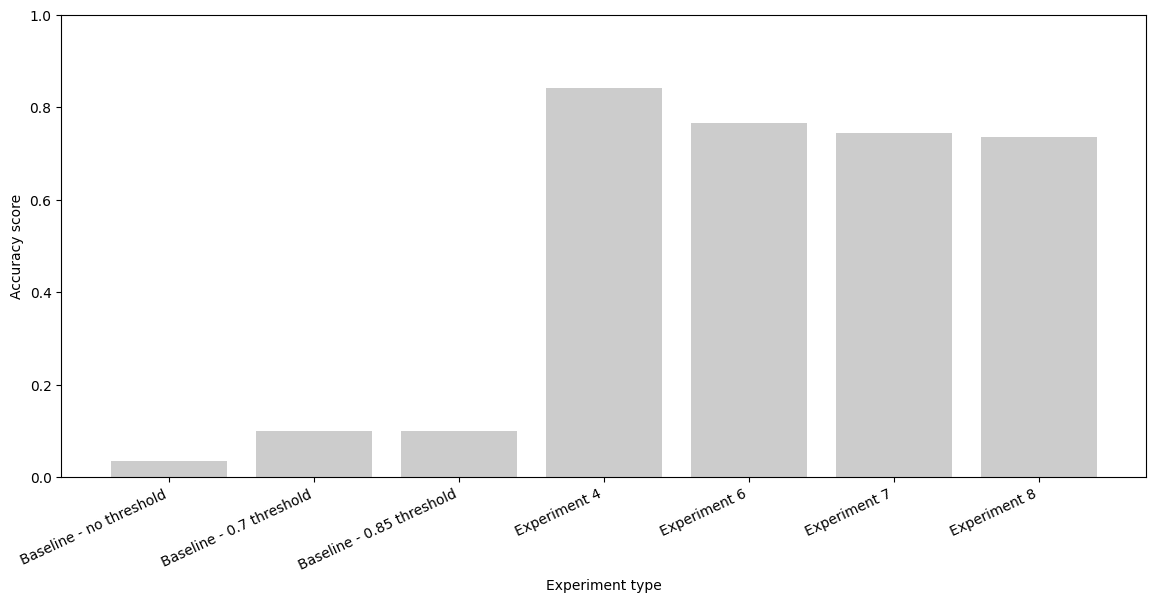

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Baseline - no threshold'),
  Text(1, 0, 'Baseline - 0.7 threshold'),
  Text(2, 0, 'Baseline - 0.85 threshold'),
  Text(3, 0, 'Experiment 4'),
  Text(4, 0, 'Experiment 6'),
  Text(5, 0, 'Experiment 7'),
  Text(6, 0, 'Experiment 8')])

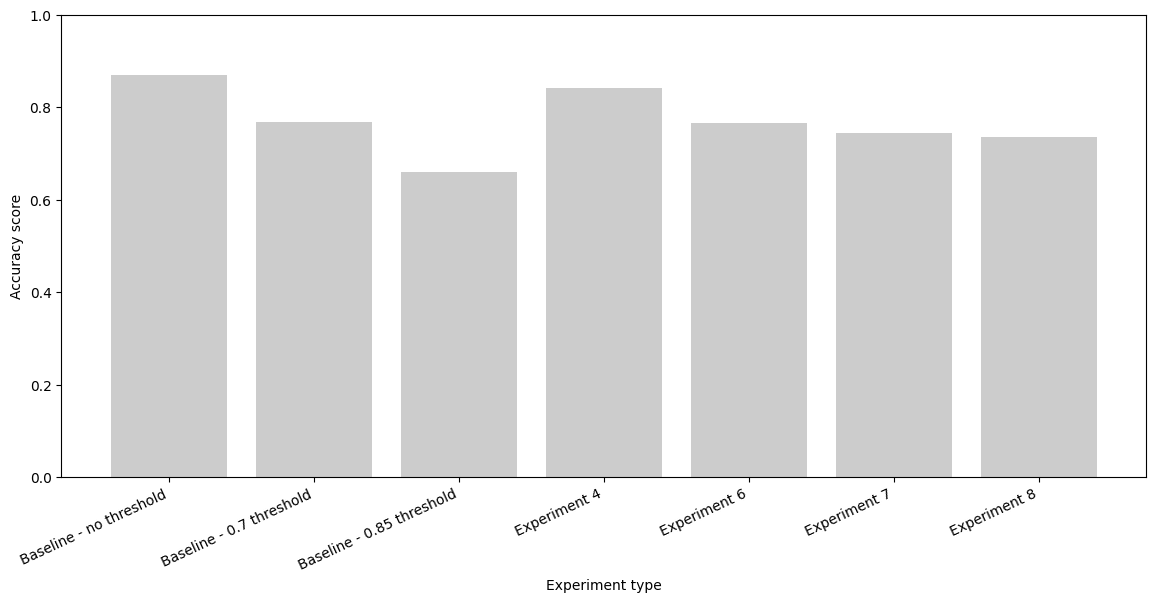

In [20]:
plt.rcParams["figure.figsize"] = (14,6)
plt.bar(exps, scores_inv_svm, color='0.8')
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score")
plt.xticks(rotation=25, ha='right')
plt.show()
plt.bar(exps, scores_not_inv_svm, color='0.8')
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score")
plt.xticks(rotation=25, ha='right')

#### knn - b 

In [60]:
scores_inv_knn = []
scores_not_inv_knn = []

In [61]:
clfs_knn_bl = KNeighborsClassifier(n_neighbors=5, p=2)

baseline_knn_score = score_inv_clf(clfs_knn_bl, 
                                    train_flattened, 
                                    y_train, 
                                    test_flattened,
                                    y_test)

scores_not_inv_knn.append(baseline_knn_score)
baseline_knn_score

0.8533

In [62]:
clfs_knn_inv_bl = KNeighborsClassifier(n_neighbors=5, p=2)

baseline_knn_score_inv = score_inv_clf(clfs_knn_inv_bl, 
                                        train_flattened, 
                                        y_train, 
                                        inv_test_flattened,
                                        y_test)

scores_inv_knn.append(baseline_knn_score_inv)
baseline_knn_score_inv

0.0335

#### b - 0.7

In [63]:
clfs_knn_bl_thr1 = KNeighborsClassifier(n_neighbors=5, p=2)
baseline_knn_score_thr1 = score_inv_clf(clfs_knn_bl_thr1, 
                                        train_flattened_inv_threshold1, 
                                        y_train, 
                                        test_flattened_threshold1, 
                                        y_test)

scores_not_inv_knn.append(baseline_knn_score_thr1)
baseline_knn_score_thr1

0.7145

In [64]:
clfs_knn_inv_bl_thr1 = KNeighborsClassifier(n_neighbors=5, p=2)
baseline_knn_score_inv_thr1 = score_inv_clf(clfs_knn_inv_bl_thr1, 
                                                train_flattened_inv_threshold1, 
                                                y_train, 
                                                test_flattened_inv_threshold1, 
                                                y_test)

scores_inv_knn.append(baseline_knn_score_inv_thr1)
baseline_knn_score_inv_thr1

0.1

#### b - 0.85

In [65]:
clfs_knn_bl_thr2 = KNeighborsClassifier(n_neighbors=5, p=2)
baseline_knn_score_thr2 = score_inv_clf(clfs_knn_bl_thr2, 
                                        train_flattened_inv_threshold2, 
                                        y_train, 
                                        test_flattened_threshold2, 
                                        y_test)

scores_not_inv_knn.append(baseline_knn_score_thr2)
baseline_knn_score_thr2

0.5826

In [66]:
clfs_knn_inv_bl_thr2 = KNeighborsClassifier(n_neighbors=5, p=2)
baseline_knn_score_inv_thr2 = score_inv_clf(clfs_knn_inv_bl_thr2, 
                                                train_flattened_inv_threshold2, 
                                                y_train, 
                                                test_flattened_inv_threshold2, 
                                                y_test)

scores_inv_knn.append(baseline_knn_score_inv_thr2)
baseline_knn_score_inv_thr2

0.1

#### 4

In [67]:
clfs_knn_exp4 = KNeighborsClassifier(n_neighbors=5, p=2)

score_exp4_knn = score_inv_clf(clfs_knn_exp4,
                                exp4_train_img_inv, 
                                y_train, 
                                exp4_test_transformed, 
                                y_test)

scores_not_inv_knn.append(score_exp4_knn)
score_exp4_knn

0.8248

In [68]:
clfs_knn_exp4_inv = KNeighborsClassifier(n_neighbors=5, p=2)

score_inv_exp4_knn = score_inv_clf(clfs_knn_exp4_inv,
                                    exp4_train_img_inv, 
                                    y_train, 
                                    exp_4_test_inv_transformed, 
                                    y_test)

scores_inv_knn.append(score_inv_exp4_knn)
score_inv_exp4_knn

0.8248

#### 6

In [69]:
clfs_knn_exp6 = KNeighborsClassifier(n_neighbors=5, p=2)

score_exp6_knn = score_inv_clf(clfs_knn_exp6,
                                exp6_train_img_inv, 
                                y_train, 
                                exp6_test_transformed, 
                                y_test)

scores_not_inv_knn.append(score_exp6_knn)
score_exp6_knn

0.7643

In [70]:
clfs_knn_exp6_inv = KNeighborsClassifier(n_neighbors=5, p=2)

score_inv_exp6_knn = score_inv_clf(clfs_knn_exp6_inv,
                                    exp6_train_img_inv, 
                                    y_train, 
                                    exp_6_test_inv_transformed, 
                                    y_test)

scores_inv_knn.append(score_inv_exp6_knn)
score_inv_exp6_knn

0.7643

#### 7

In [71]:
clfs_knn_exp7 = KNeighborsClassifier(n_neighbors=5, p=2)

score_exp7_knn = score_inv_clf(clfs_knn_exp7,
                                    exp7_train_img_inv, 
                                    y_train, 
                                    exp7_test_transformed, 
                                    y_test)

scores_not_inv_knn.append(score_exp7_knn)
score_exp7_knn

0.7911

In [72]:
clfs_knn_exp7_inv = KNeighborsClassifier(n_neighbors=5, p=2)

score_inv_exp7_knn = score_inv_clf(clfs_knn_exp7_inv,
                                    exp7_train_img_inv, 
                                    y_train, 
                                    exp_7_test_inv_transformed, 
                                    y_test)

scores_inv_knn.append(score_inv_exp7_knn)
score_inv_exp7_knn

0.7911

#### 8

In [73]:
clfs_knn_exp8 = KNeighborsClassifier(n_neighbors=5, p=4)

score_exp8_knn = score_inv_clf(clfs_knn_exp8,
                                exp8_train_img_inv, 
                                y_train, 
                                exp8_test_transformed, 
                                y_test)

scores_not_inv_knn.append(score_exp8_knn)
score_exp8_knn

0.7646

In [74]:
clfs_knn_exp8_inv = KNeighborsClassifier(n_neighbors=5, p=4)

score_inv_exp8_knn = score_inv_clf(clfs_knn_exp8_inv,
                                    exp8_train_img_inv, 
                                    y_train, 
                                    exp_8_test_inv_transformed, 
                                    y_test)

scores_inv_knn.append(score_inv_exp8_knn)
score_inv_exp8_knn

0.7646

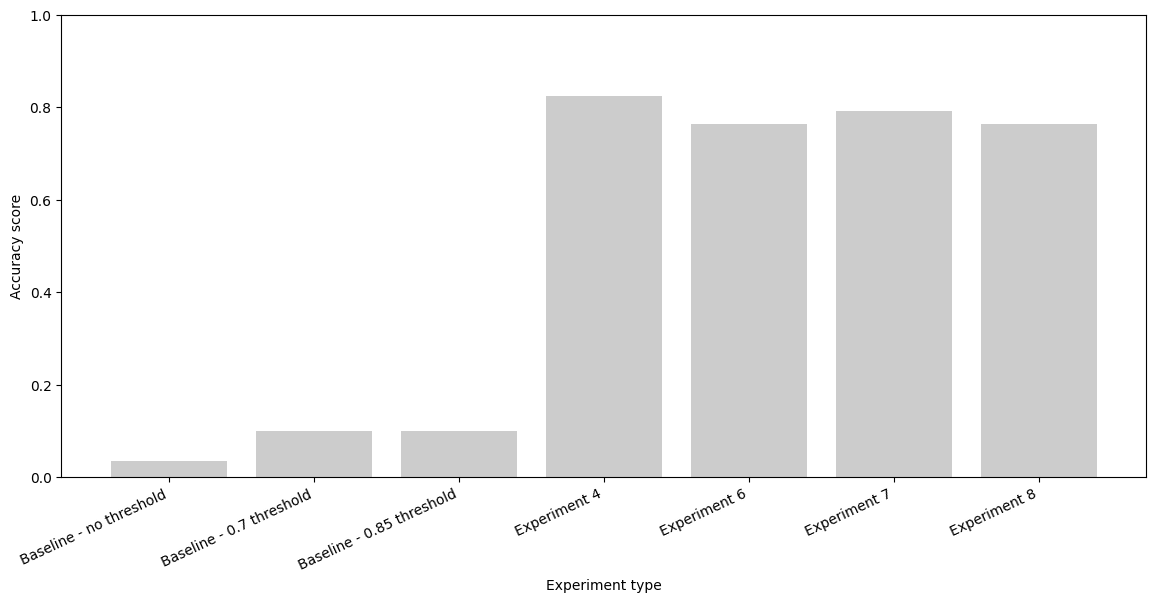

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Baseline - no threshold'),
  Text(1, 0, 'Baseline - 0.7 threshold'),
  Text(2, 0, 'Baseline - 0.85 threshold'),
  Text(3, 0, 'Experiment 4'),
  Text(4, 0, 'Experiment 6'),
  Text(5, 0, 'Experiment 7'),
  Text(6, 0, 'Experiment 8')])

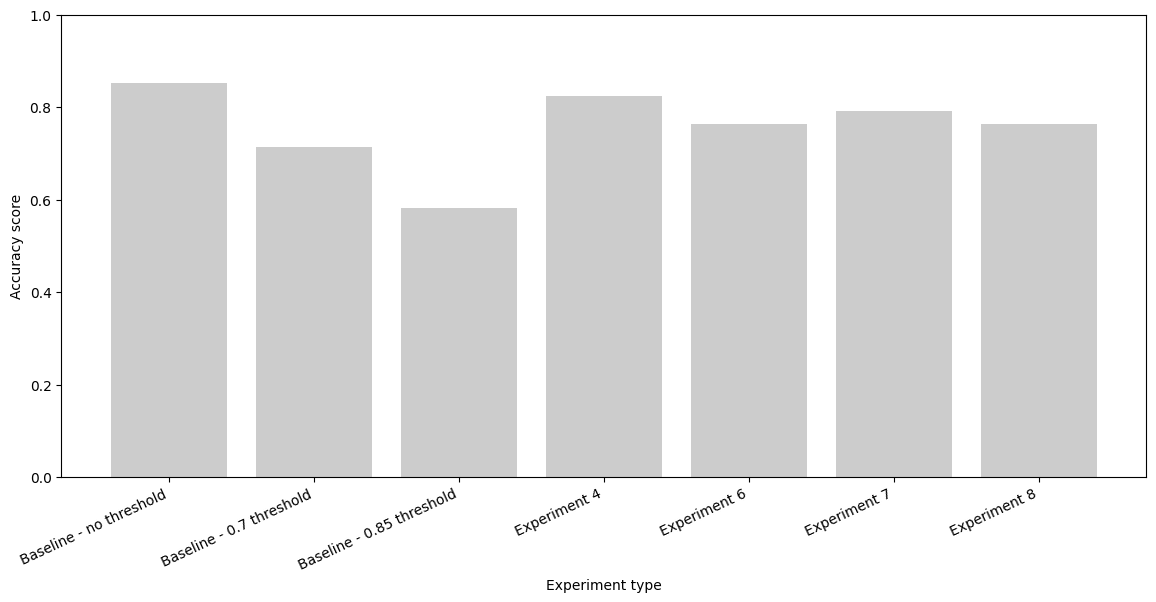

In [21]:
plt.rcParams["figure.figsize"] = (14,6)
plt.bar(exps, scores_inv_knn, color='0.8')
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score")
plt.xticks(rotation=25, ha='right')
plt.show()
plt.bar(exps, scores_not_inv_knn, color='0.8')
plt.ylim([.0, 1.])
plt.xlabel("Experiment type") 
plt.ylabel("Accuracy score")
plt.xticks(rotation=25, ha='right')

In [16]:
scores_inv = [0.0054, 0.1, 0.1, 0.793, 0.7446, 0.7704, 0.7448]
scores_not_inv = [0.8431, 0.7411, 0.641, 0.7932, 0.7442, 0.7703, 7449]
scores_inv_svm = [0.0351, 0.1, 0.1, 0.8426, 0.7667, 0.7443, 0.7352]
scores_not_inv_svm = [0.8694, 0.7684, 0.6606, 0.8426, 0.7667, 0.7441, 0.7352]
scores_inv_knn = [0.0335, 0.1, 0.1, 0.8248, 0.7643, 0.7911, 0.7646]
scores_not_inv_knn = [0.8533, 0.7145, 0.5826, 0.8248, 0.7643, 0.7911, 0.7646]

In [17]:
print(scores_inv)
print(scores_not_inv)
print(scores_inv_svm)
print(scores_not_inv_svm)
print(scores_inv_knn)
print(scores_not_inv_knn)

[0.0054, 0.1, 0.1, 0.793, 0.7446, 0.7704, 0.7448]
[0.8431, 0.7411, 0.641, 0.7932, 0.7442, 0.7703, 7449]
[0.0351, 0.1, 0.1, 0.8426, 0.7667, 0.7443, 0.7352]
[0.8694, 0.7684, 0.6606, 0.8426, 0.7667, 0.7441, 0.7352]
[0.0335, 0.1, 0.1, 0.8248, 0.7643, 0.7911, 0.7646]
[0.8533, 0.7145, 0.5826, 0.8248, 0.7643, 0.7911, 0.7646]
